In [682]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random
import plotly.graph_objects as go
import scipy.stats as stats

In [683]:
# load data
ego_updates = pd.read_csv('../Clean/ego_updates.csv')
stereo_updates = pd.read_csv('../Clean/stereo_updates.csv')
updates = pd.read_csv('../Clean/updates.csv')
stereo_characteristics_beliefs = pd.read_csv('../Clean/stereo_characteristics_beliefs.csv')


In [684]:
stereo_updates['code'].unique()

array(['0kxsrg73', '1zb27tea', '36b7nxpg', '3cv0gsso', '4d7lvql9',
       '4kecnisx', '56op1uib', '6sybrxjn', '6zd6yym2', '78sdphga',
       'a22g0du7', 'byf6tjt0', 'cioxyqvq', 'cl0818oa', 'dk93ewke',
       'ffd2bxk4', 'g2p53iqv', 'idzf7yro', 'ilooy3i8', 'j3r6tuv8',
       'jk70axat', 'jka2nr9v', 'k43107gm', 'ko3jhnbj', 'lmiiifw0',
       'n86dcmzu', 'ncvtgyzn', 'oqf1d07l', 'q9jar1of', 'uz5m20q1',
       'v3yunf9n', 'wursesku', 'zwzznpo6'], dtype=object)

# Initial beliefs (reported and revealed)

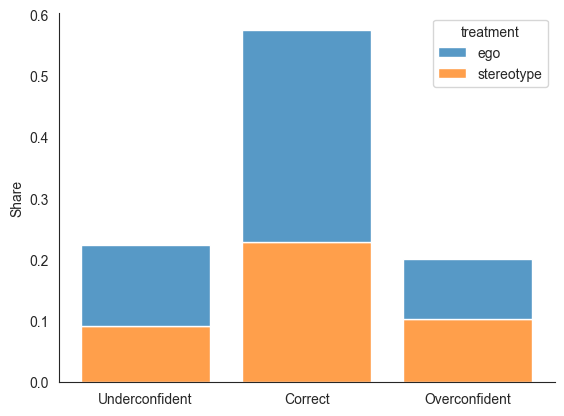

In [685]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates, 
                  multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Underconfident', 'Correct', 'Overconfident'])
plt.ylabel('Share')

#save figure
plt.savefig('../figures/misspecification_hist.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'round 10')

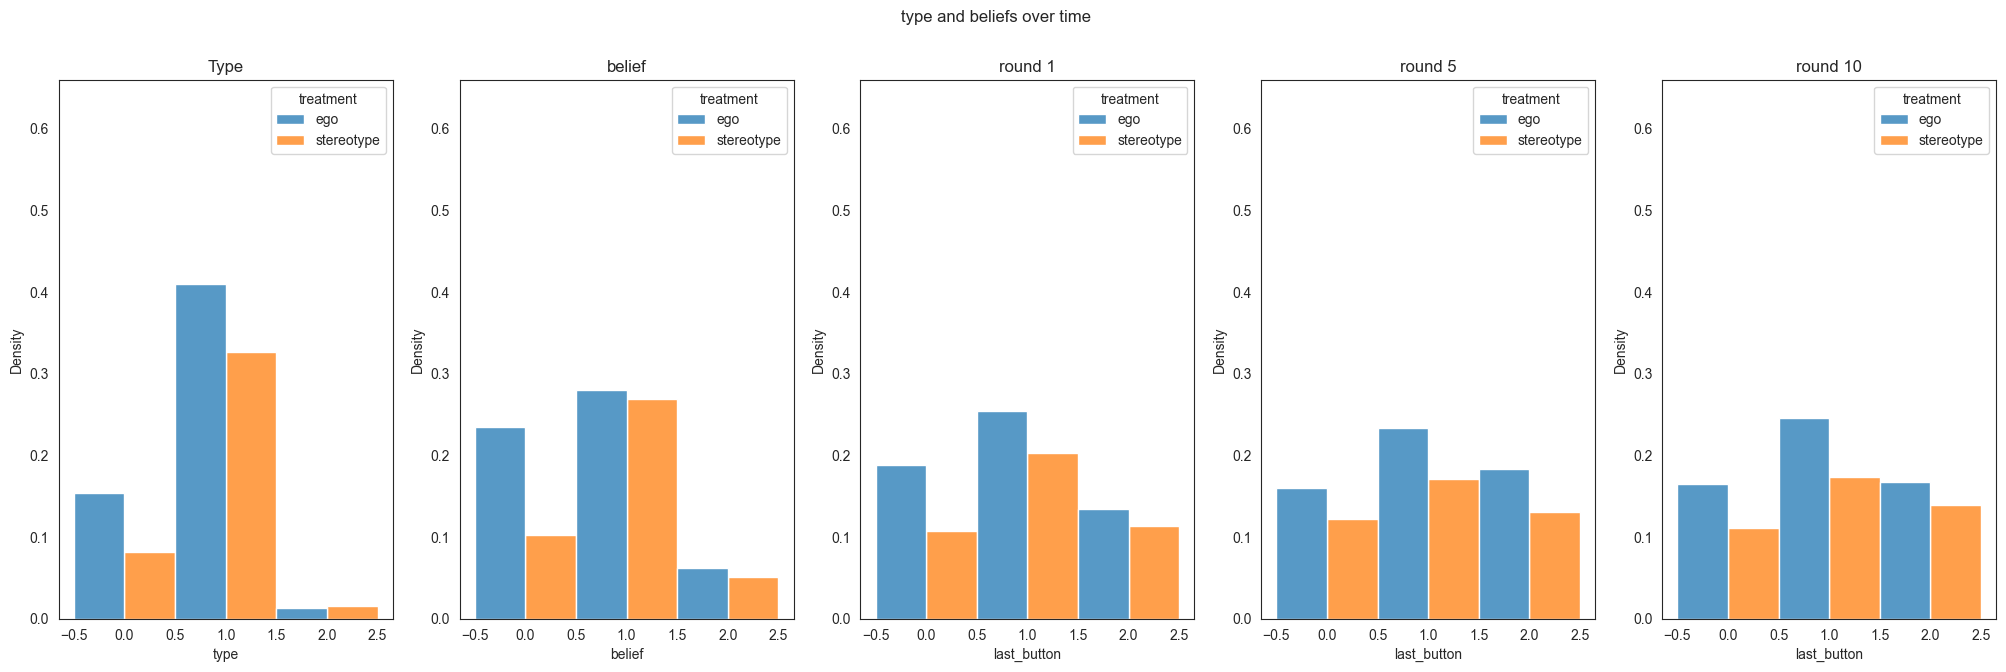

In [686]:
fig, axs = plt.subplots(1, 5, figsize=(25, 7))

fig.suptitle('type and beliefs over time')

sns.histplot(data=updates, x='type', ax=axs[0], discrete=True, hue='treatment', multiple='dodge', stat='density')
sns.histplot(data=updates, x='belief', ax=axs[1], discrete=True, hue='treatment', multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==1], x='last_button', ax=axs[2], discrete=True, hue='treatment', multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==5], x='last_button', ax=axs[3], discrete=True, hue='treatment', multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==11], x='last_button', ax=axs[4], discrete=True, hue='treatment', multiple='dodge', stat='density')

axs[0].set_ylim((0, .66))
axs[1].set_ylim((0, .66))
axs[2].set_ylim((0, .66))
axs[3].set_ylim((0, .66))
axs[4].set_ylim((0, .66))

axs[0].set_title('Type')
axs[1].set_title('belief')
axs[2].set_title('round 1')
axs[3].set_title('round 5')
axs[4].set_title('round 10')


In [687]:
# need to rename the columns type and rate from updates to theta and omega
updates = updates.rename(columns={'type':'theta', 'rate':'omega'})

            last_button_consistent
treatment                         
ego                       0.733333
stereotype                0.681818
            last_button_consistent
treatment                         
ego                       0.581481
stereotype                0.449495
            last_button_correct
treatment                      
ego                    0.511111
stereotype             0.409091
            last_button_correct
treatment                      
ego                    0.474074
stereotype             0.398990


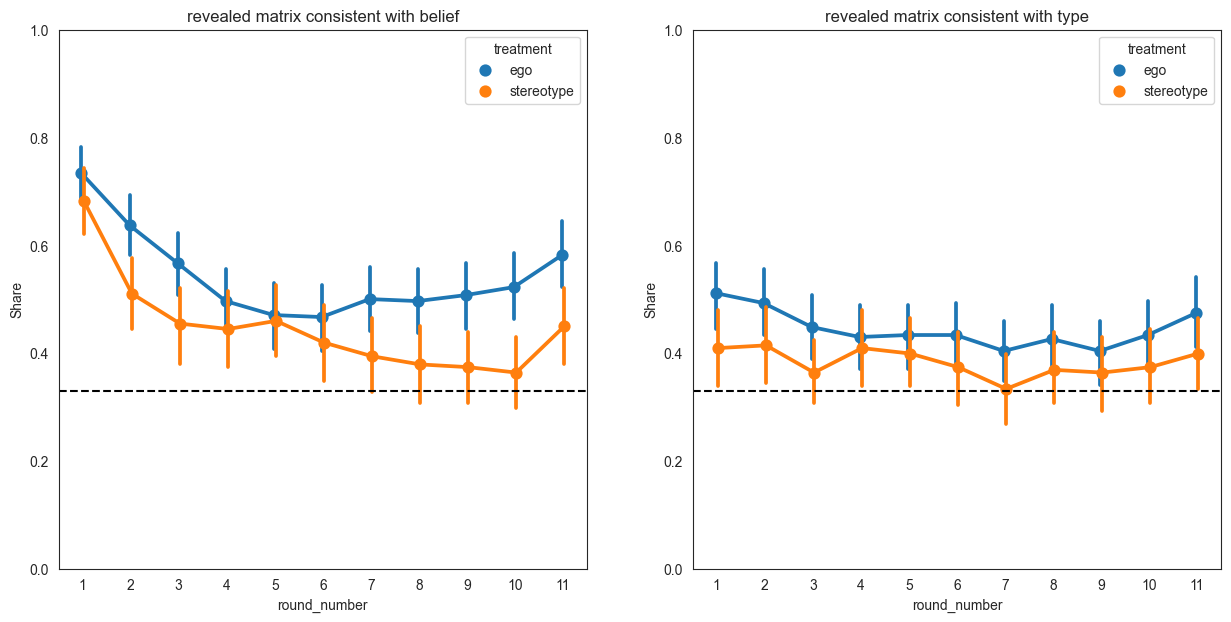

In [688]:
# calculate the share of player_codes for which last_button in round_number 1 is the same as belief
updates['last_button_consistent'] = updates['last_button'] == updates['belief']
updates['last_button_consistent'] = updates['last_button_consistent'].astype(int)

print(updates.loc[updates['round_number']==1, ['last_button_consistent', 'treatment']].groupby('treatment').mean())

print(updates.loc[updates['round_number']==11, ['last_button_consistent', 'treatment']].groupby('treatment').mean())

# calculate the share of subjects for whom the last button is the same as their theta
updates['last_button_correct'] = updates['last_button'] == updates['theta']
updates['last_button_correct'] = updates['last_button_correct'].astype(int)

print(updates.loc[updates['round_number']==1, ['last_button_correct', 'treatment']].groupby('treatment').mean())
print(updates.loc[updates['round_number']==11, ['last_button_correct', 'treatment']].groupby('treatment').mean())


# plot the share of player_codes for which last_button in round_number 1 is the same as belief
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style("white")
sns.pointplot(data=updates, x='round_number', y='last_button_consistent', hue='treatment', dodge=True, ax=axs[0])
axs[0].set_ylim((0, 1))
axs[0].set_title('revealed matrix consistent with belief')
axs[0].set_ylabel('Share')

sns.pointplot(data=updates, x='round_number', y='last_button_correct', hue='treatment', dodge=True, ax=axs[1])
axs[1].set_ylim((0, 1))
axs[1].set_title('revealed matrix consistent with type')
axs[1].set_ylabel('Share')

#plot a horizontal line at .33 in each plot
axs[0].axhline(y=.33, color='black', linestyle='--')
axs[1].axhline(y=.33, color='black', linestyle='--')


(0.0, 1.0)

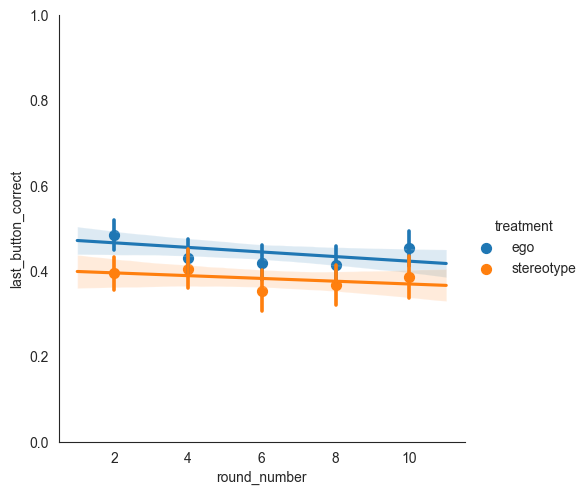

In [689]:
sns.lmplot(data=updates, x='round_number', y='last_button_correct', hue='treatment', x_bins=5)
plt.ylim((0, 1))

(0.0, 2.0)

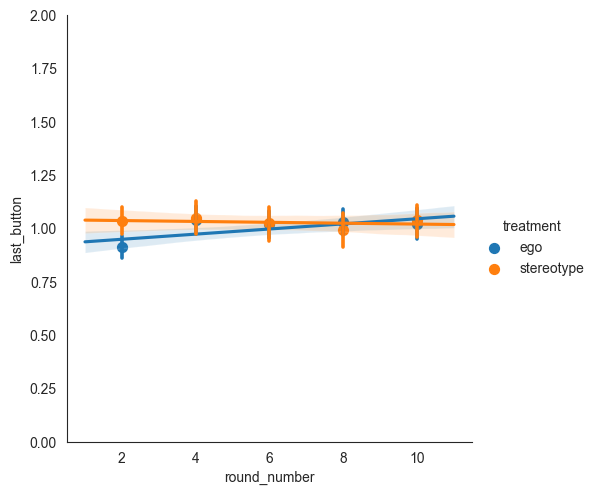

In [690]:
sns.lmplot(data=updates, x='round_number', y='last_button', hue='treatment', x_bins=5)
plt.ylim((0, 2))

In [691]:
# create a column in updates called treatment_indic that is 1 if the treatment is stereotype
updates['treatment_indic'] = np.where(updates['treatment']=='stereotype', 1, 0)
# create a column in updates called interaction that is the product of update_indic and round_number
updates['interaction'] = updates['treatment_indic']*updates['round_number']
# regress last_button on round_number, update_indic and the interaction between the two
import statsmodels.api as sm
X = updates[['round_number', 'treatment_indic', 'interaction']]
y = updates['last_button']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            last_button   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.086
Date:                Tue, 26 Sep 2023   Prob (F-statistic):             0.0261
Time:                        22:16:32   Log-Likelihood:                -6018.1
No. Observations:                5148   AIC:                         1.204e+04
Df Residuals:                    5144   BIC:                         1.207e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9245      0.031     30.150      0.000       0.864       0.985
round_number        0.0120      0.005      2.659      0.008       0.003       0.021
treatment_indic     0.1159      0.047      2.458      0.014       0.023       0.208
interaction        -0.0141      0.007     -2.027      0.043      -0.028      -0.000
==============================================================================
Omnibus:                   131266.359   Durbin-Watson:                   1.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.029
Skew:                          -0.019   Prob(JB):                     1.23e-85
Kurtosis:                       1.650   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Belief Changes

In [692]:
# assign a number code to each of the topics to create an id column that has the participant code and the topic they were updating on.
updates.loc[updates['topic']=='Math', 'topic_num'] = '1'
updates.loc[updates['topic']=='Science and Technology', 'topic_num'] = '2'
updates.loc[updates['topic']=='Verbal', 'topic_num'] = '3'
updates.loc[updates['topic']=='Pop-Culture and Art', 'topic_num'] = '4'
updates.loc[updates['topic']=='Sports and Video Games', 'topic_num'] = '5'
updates.loc[updates['topic']=='US Geography', 'topic_num'] = '6'

# make a column that combines the participant code and the topic number into a singe id for a participant in a task.
updates['player_code'] = updates['code']+updates['topic_num']

updates.reset_index(inplace=True)




In [693]:
### Add columns to determine how the Subject's beliefs about their type changed across rounds
# for each task, determine whether their belief changed from the initial belief or not.
# check at every row if the belief is different from the last_button. 
updates['current_belief_start'] = updates['last_button'] - updates['belief']

# for rows in which rond_number is 2 or more, check if last_button is the same as last_button in the previous round_number for that player_code
# and register the size of the belief change in the column belief_change
updates['belief_change'] = np.where(updates['round_number']>1, 
                                     updates['last_button'] - updates['last_button'].shift(1), 
                                     updates['current_belief_start'])

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['change_indicator'] = 0
updates.loc[updates['belief_change']!=0, 'change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['change_indicator_sum'] = updates.groupby('player_code')['change_indicator'].transform('sum')





In [694]:
epsilon_ego = updates.loc[updates['treatment']=='ego', 'change_indicator_sum'].mean()
epsilon_stereo = updates.loc[updates['treatment']=='stereotype', 'change_indicator_sum'].mean()

In [695]:
stats.ttest_ind(updates.loc[updates['treatment']=='ego', 'change_indicator_sum'], updates.loc[updates['treatment']=='stereotype', 'change_indicator_sum'])

Ttest_indResult(statistic=-11.36641648104487, pvalue=1.3814461934252632e-29)

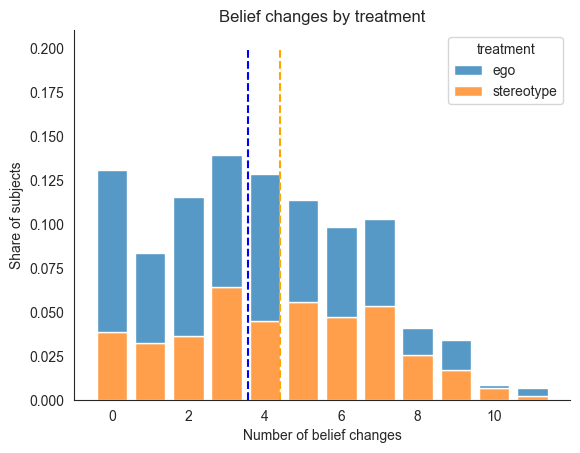

In [696]:
# if the indicator is more than 0 then the belief changed at least once and these subjects cannot possibly be dogmatic.
# plot the share of subjects for whom the belief never changed and the share for whom it did
sns.set_style("white")
sns.histplot(data=updates, x='change_indicator_sum', hue='treatment', multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('Number of belief changes')
plt.ylabel('Share of subjects')
plt.title('Belief changes by treatment')

plt.vlines(x=epsilon_ego, ymin=0, ymax=.2, linestyles='--', colors='blue', label='ego mean')
plt.vlines(x=epsilon_stereo, ymin=0, ymax=.2, linestyles='--', colors='orange', label='stereo mean')

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/1888847311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11['first_last'] = round_11['last_button'] - round_11['theta']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/1888847311.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11.loc[round_11['first_last']<0, 'last_specification'] = 'under'


Text(0.5, 1.0, 'belief from guess to last round')

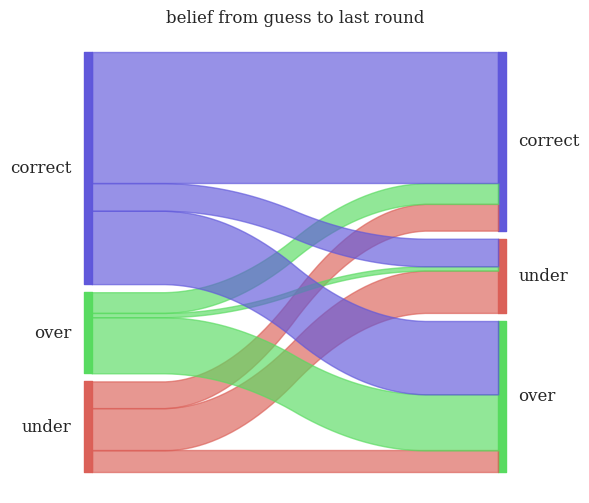

In [697]:
# create a data frame with the last round for each subject
round_11 = updates.loc[updates['round_number']==11]
# check the difference between last_button iminus theta
round_11['first_last'] = round_11['last_button'] - round_11['theta']
# add a column called last_specification that is 'under' if the difference is negative, correct if they are the same and 2 if the difference is positive
round_11.loc[round_11['first_last']<0, 'last_specification'] = 'under'
round_11.loc[round_11['first_last']==0, 'last_specification'] = 'correct'
round_11.loc[round_11['first_last']>0, 'last_specification'] = 'over'

#make a sankey diagram from the inital misspecification to the final one
from pySankey.sankey import sankey
sankey(round_11["misspecification"], round_11["last_specification"], fontsize=12)

plt.title('belief from guess to last round')

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/3704985241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1['first_last'] = round_1['last_button'] - round_1['theta']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/3704985241.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1.loc[round_1['first_last']<0, 'specification'] = 'under'


Text(0.5, 1.0, 'belief round 1 to last round')

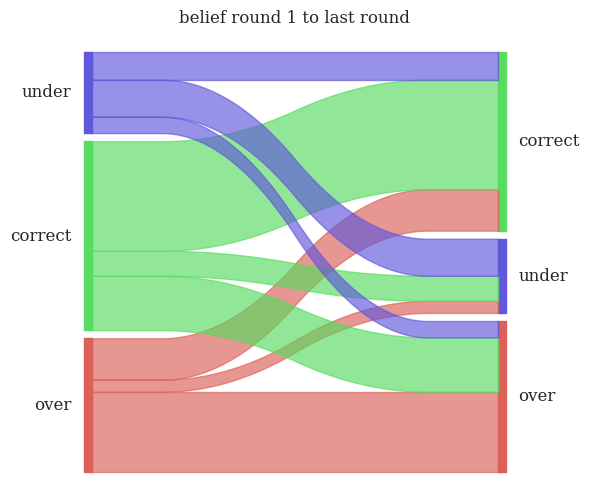

In [698]:
# create a data frame with the last round for each subject
round_1 = updates.loc[updates['round_number']==1]
# check the difference between last_button iminus theta
round_1['first_last'] = round_1['last_button'] - round_1['theta']
# add a column called last_specification that is 'under' if the difference is negative, correct if they are the same and 2 if the difference is positive
round_1.loc[round_1['first_last']<0, 'specification'] = 'under'
round_1.loc[round_1['first_last']==0, 'specification'] = 'correct'
round_1.loc[round_1['first_last']>0, 'specification'] = 'over'

#make a sankey diagram from the inital misspecification to the final one
sankey(round_1['specification'], round_11["last_specification"], fontsize=12)

plt.title('belief round 1 to last round')

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/699583036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_5['first_last'] = round_5['last_button'] - round_5['theta']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/699583036.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_5.loc[round_5['first_last']<0, 'fifth_specification'] = 'under'


Text(0.5, 1.0, 'beliefs from guess to round 5')

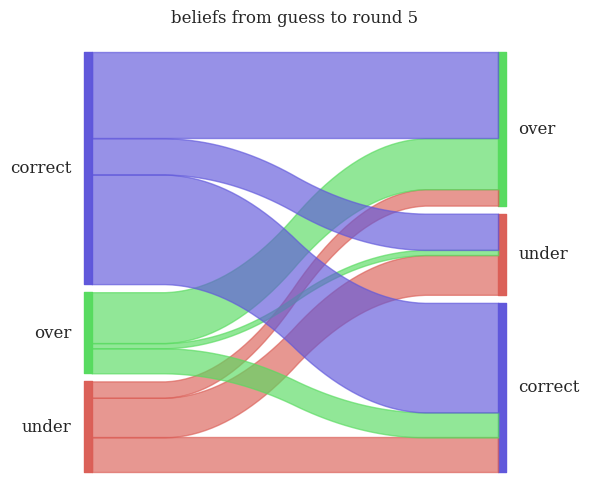

In [699]:
# create a data frame with the fifth round for each subject
round_5 = updates.loc[updates['round_number']==5]
# check the difference between last_button iminus theta
round_5['first_last'] = round_5['last_button'] - round_5['theta']
# add a column called last_specification that is 'under' if the difference is negative, correct if they are the same and 2 if the difference is positive
round_5.loc[round_5['first_last']<0, 'fifth_specification'] = 'under'
round_5.loc[round_5['first_last']==0, 'fifth_specification'] = 'correct'
round_5.loc[round_5['first_last']>0, 'fifth_specification'] = 'over'


#make a sankey diagram from the inital misspecification to the final one
from pySankey.sankey import sankey
sankey(round_5["misspecification"], round_5["fifth_specification"], fontsize=12)

plt.title('beliefs from guess to round 5')

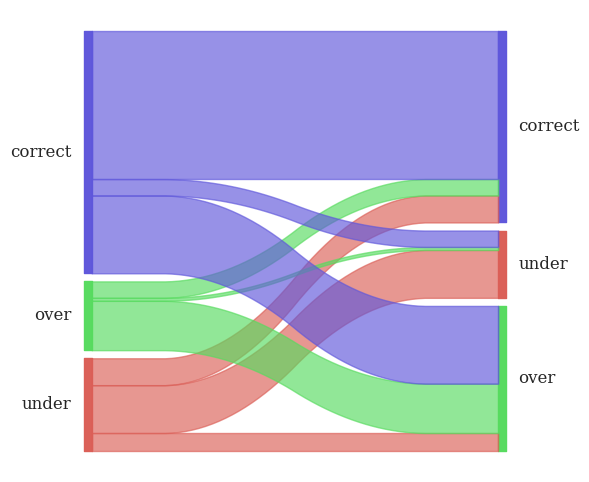

In [700]:
sankey(round_11.loc[round_11['treatment']=='ego', 'misspecification'], round_11["last_specification"], fontsize=12)

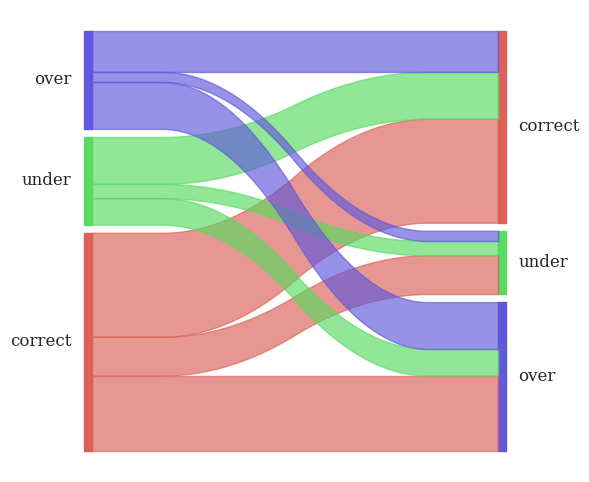

In [701]:
sankey(round_11.loc[round_11['treatment']=='stereotype', 'misspecification'], round_11["last_specification"], fontsize=12)

In [702]:
# compute the number of subjects that started in each specification and ended in each of them
round_11.groupby(['misspecification', 'last_specification']).count()['code']

misspecification  last_specification
correct           correct               152
                  over                   85
                  under                  32
over              correct                24
                  over                   65
                  under                   5
under             correct                31
                  over                   25
                  under                  49
Name: code, dtype: int64

Text(0.5, 1.0, 'last button first to last round')

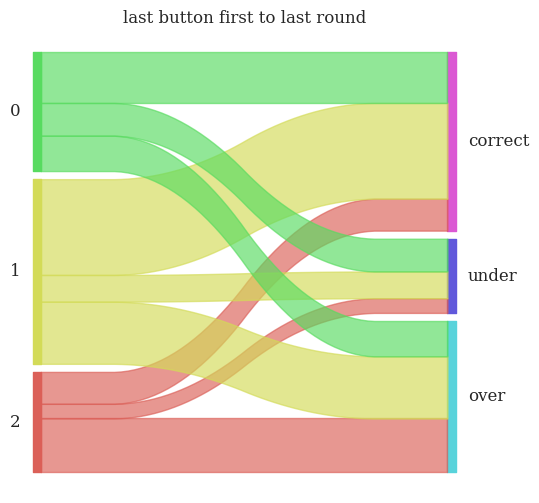

In [703]:
sankey(updates.loc[updates['round_number']==1, "last_button"], round_11['last_specification'], fontsize=12)

plt.title('last button first to last round')

Text(0.5, 1.0, 'last button first to last round')

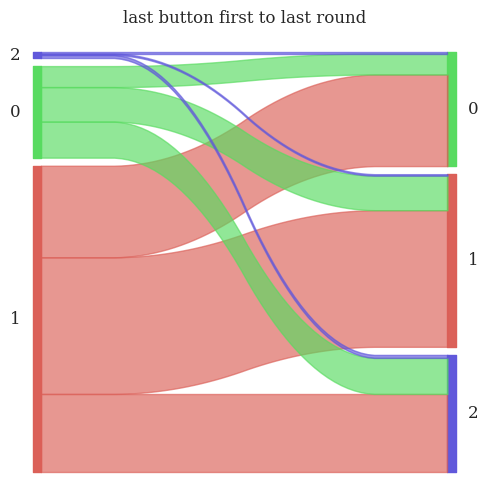

In [704]:
sankey(updates.loc[(updates['round_number']==1) & (updates['misspecification']=='correct'), "belief"], updates.loc[updates['round_number']==11, "last_button"], fontsize=12)

plt.title('last button first to last round')

In [705]:
round_1['misspecification'].value_counts()/round_1['misspecification'].value_counts().sum()

correct    0.574786
under      0.224359
over       0.200855
Name: misspecification, dtype: float64

In [706]:
round_11['last_specification'].value_counts()/round_11['last_specification'].value_counts().sum()

correct    0.442308
over       0.373932
under      0.183761
Name: last_specification, dtype: float64

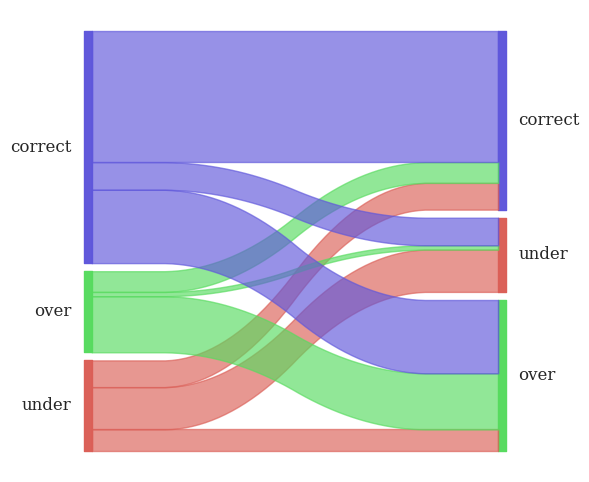

In [707]:
sankey(round_11["misspecification"], round_11["last_specification"], fontsize=12)

# Which misspecifications persist the most?
Is there any evidence that people are overconfident?

In [708]:
#plot the share of subjects that started in each specification and ended in each of them
round_11.groupby(['misspecification', 'last_specification']).count()['code']/round_11.groupby(['misspecification']).count()['code']


misspecification  last_specification
correct           correct               0.565056
                  over                  0.315985
                  under                 0.118959
over              correct               0.255319
                  over                  0.691489
                  under                 0.053191
under             correct               0.295238
                  over                  0.238095
                  under                 0.466667
Name: code, dtype: float64

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/873372847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11.loc[round_11['last_specification']=='under', 'last_specification_num'] = -1


(0.0, 1.0)

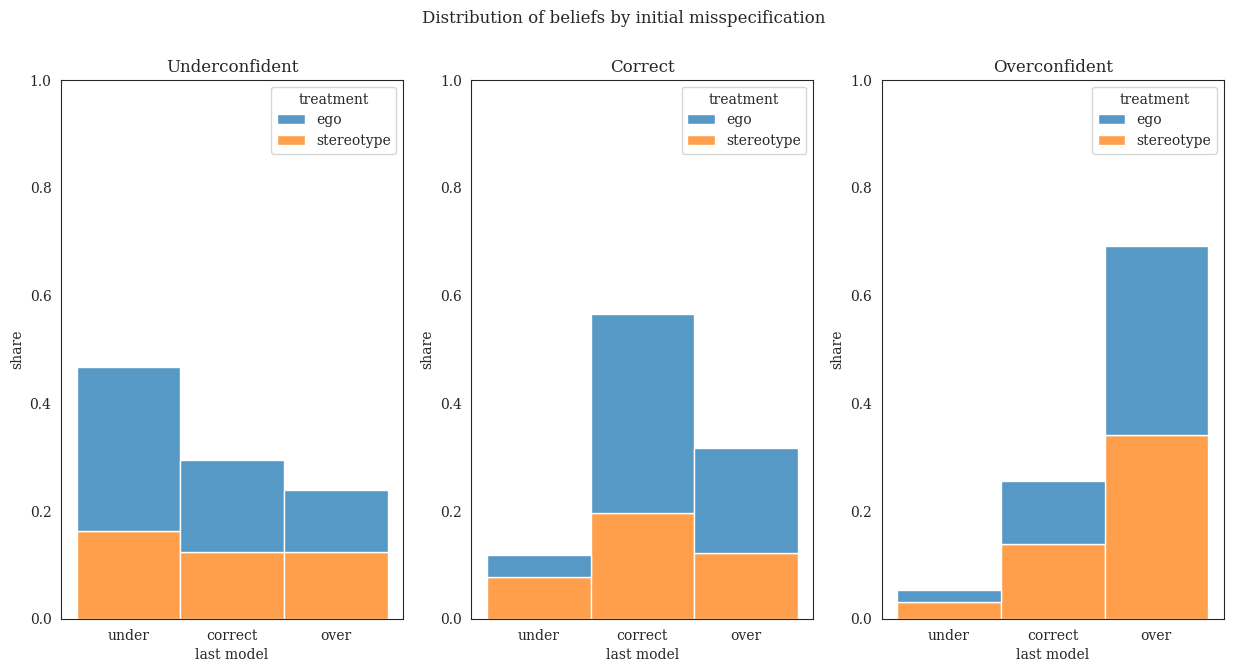

In [709]:
# for the data frame round_11, create a column called last_specification_num that is -1 if the last_specification is under, 0 if it is correct and 1 if it is over
round_11.loc[round_11['last_specification']=='under', 'last_specification_num'] = -1
round_11.loc[round_11['last_specification']=='correct', 'last_specification_num'] = 0
round_11.loc[round_11['last_specification']=='over', 'last_specification_num'] = 1

# plot 3 histograms side by side for each initial misspecification
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('Distribution of beliefs by initial misspecification')
# the first histogram is for those who began underconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='under'], x='last_specification_num',  ax=axs[0], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[0].set_title('Underconfident')
axs[0].set_ylabel('share')
axs[0].set_xlabel('last model')
axs[0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0].set_ylim((0, 1))


# the second histogram is for those who began correct, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='correct'], x='last_specification_num', ax=axs[1], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[1].set_title('Correct')
axs[1].set_ylabel('share')
axs[1].set_xlabel('last model')
axs[1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1].set_ylim((0, 1))

# the third histogram is for those who began overconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='over'], x='last_specification_num', ax=axs[2], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[2].set_title('Overconfident')
axs[2].set_ylabel('share')
axs[2].set_xlabel('last model')
axs[2].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[2].set_ylim((0, 1))


# Compute the Likelihoods

In [710]:
## Likelihoods
#for each subject, calulate the likelihood of each of the types given the signals they saw.
# the probability matrices are needed for th calculatin of the likelihood
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]

for i in range(len(updates['player_code'].unique())):
    # get a single path for a single player
    c = updates['player_code'].unique()[i]
    player = updates.loc[updates['player_code']==c, :]
    # for each round get the history of (effort, signal) pairs up to that round
    p_t=[]
    lr_t=[]
    prior = [1/3, 1/3, 1/3]

    for t in [a+2 for a in range(10)]:
        
        e_t = int(player.loc[player['round_number']==t, 'effort'])
        theta = int(player.loc[player['round_number']==t, 'theta'])
        belief_prev = int(player.loc[player['round_number']==t-1, 'last_button'])
        belief_new = int(player.loc[player['round_number']==t, 'last_button'])
        omega = int(player.loc[player['round_number']==t, 'omega'])
        s_t = int(player.loc[player['round_number']==t, 'signal'])
        f_t = 10-s_t

        # update the belief about omega for each of the types separately
        posterior_new = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0))))
        posterior_prev = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0))))

        p_new = sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0)@posterior_new
        p_prev = sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0)@posterior_prev
        # multiply all the elements in p_true and p_belief
        l_new = np.prod(p_new)
        l_prev = np.prod(p_prev)
        # calculate the likelihood ratio
        lr_t.append(l_new/l_prev)
    # add a column to the updates data frame with the likelihood ratio for each round
    updates.loc[(updates['player_code']==c) & (updates['round_number']>=2), 'lr'] = lr_t

# Compute alpha


In [711]:
len(updates.loc[(updates['lr']>15), 'lr'])/len(updates['lr'])

0.003885003885003885

In [712]:
# calculate the average of lr for the rows in which change_indicator is 1 
# (dropping paths in which subjects changed their belief more than 9 times)
alpha = updates.loc[(updates['change_indicator']==1)& (updates['change_indicator_sum']<=9) & (updates['lr']<=15), 'lr'].mean()
alpha

1.4849490061498292

In [713]:
# calculate alpha for each treatment separately, still dropping paths in which subjects changed their belief more than 9 times
alpha_ego = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['treatment']=='ego')& (updates['lr']<15), 'lr'].mean()
alpha_stereo = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['treatment']=='stereotype')& (updates['lr']<15), 'lr'].mean()

print('alpha is ' + str(alpha_ego) + 'in the ego condition')
print('alpha is ' + str(alpha_stereo) + 'in the stereotype condition')

alpha is 1.525232336768125in the ego condition
alpha is 1.4398889960115773in the stereotype condition


## Test if the alphas are different in the two treatments

In [714]:
stats.ttest_ind(updates.loc[(updates['treatment']=='ego') & (updates['round_number']>2) & (updates['change_indicator_sum']<=9) & 
                            (updates['change_indicator']==1) & (updates['lr']<15) , 'lr'], 
                updates.loc[(updates['treatment']=='stereotype') & (updates['round_number']>2) & (updates['change_indicator_sum']<=9) & 
                            (updates['change_indicator']==1) & (updates['lr']<15) , 'lr'])

Ttest_indResult(statistic=0.7923498602497303, pvalue=0.42828813039557867)

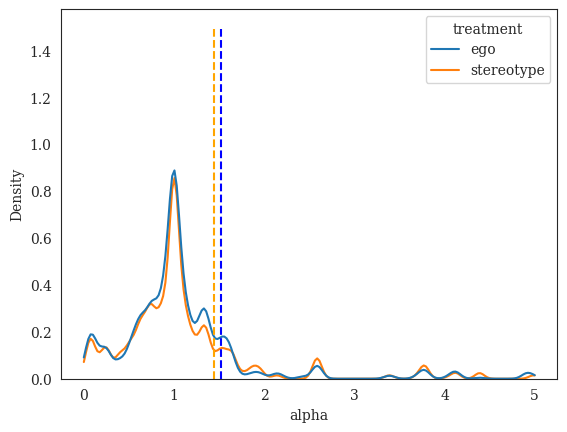

In [715]:
# estimate the distribution of alpha
# take the log of the lr
updates['log_lr'] = np.log(updates['lr'])
# plot the distribution of log_lr
sns.kdeplot(data = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['lr']<=15)], x = 'lr', 
            hue='treatment', bw_adjust=.1, clip=(0, 5))
plt.xlabel('alpha')
# plt.vlines([alpha], 0, 1.5, color = 'gray', linestyles='--')
plt.vlines([alpha_ego], 0, 1.5, color = 'blue', linestyles='--', label=('ego mean'))
plt.vlines([alpha_stereo], 0, 1.5, color = 'orange', linestyles='--', label=('stereo mean'))


In [716]:
alpha_subjects = updates[updates['change_indicator']==1].groupby(['code'])['lr', 'theta', 'belief', 'last_button'].mean()
alpha_subjects.reset_index(inplace=True)

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/2835870841.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  alpha_subjects = updates[updates['change_indicator']==1].groupby(['code'])['lr', 'theta', 'belief', 'last_button'].mean()


<Axes: xlabel='lr', ylabel='Count'>

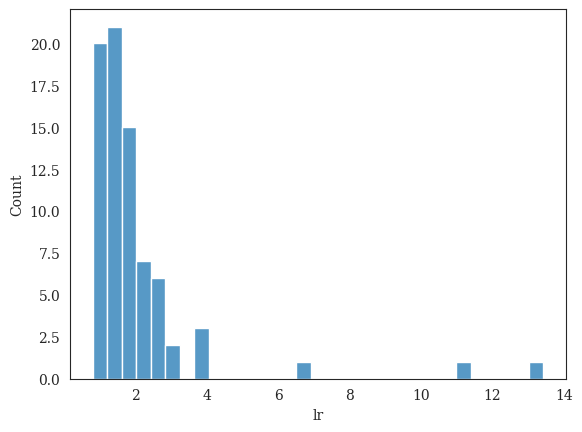

In [717]:
sns.histplot(data = alpha_subjects[alpha_subjects['lr']<15], x = 'lr')

Text(0.5, 1.0, 'Number of belief changes by initial misspecification')

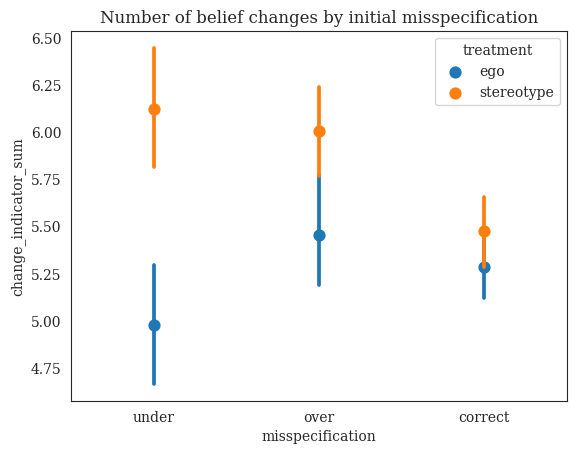

In [718]:
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9)], y='change_indicator_sum', x='misspecification', join =False, hue='treatment')
plt.title('Number of belief changes by initial misspecification')

# Disaggregate Alpha

Text(0.5, 1.0, 'Switching Threshold by treatment')

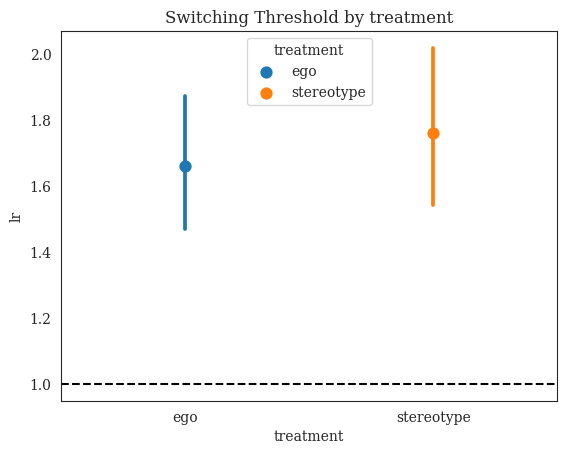

In [719]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['lr']<50)], y='lr', x='treatment', join =False, hue='treatment')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by treatment')

Text(0.5, 1.0, 'switching threshold by misspecifiaction')

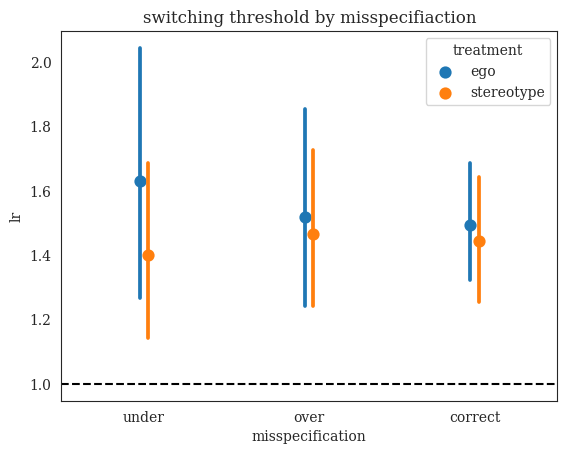

In [720]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['lr']<15)], 
              y='lr', x='misspecification', join =False, hue='treatment', dodge=True)
plt.axhline(y=1, color='black', linestyle='--')
plt.title('switching threshold by misspecifiaction')

In [721]:
#take code of the observations in which the 'lr' is grater than 50
codes = updates.loc[(updates['lr']>=50) & (updates['round_number']>2), 'player_code'].unique()
# get the data from the observations that have a player_code in codes
abnormals = updates[updates['player_code'].isin(codes)]

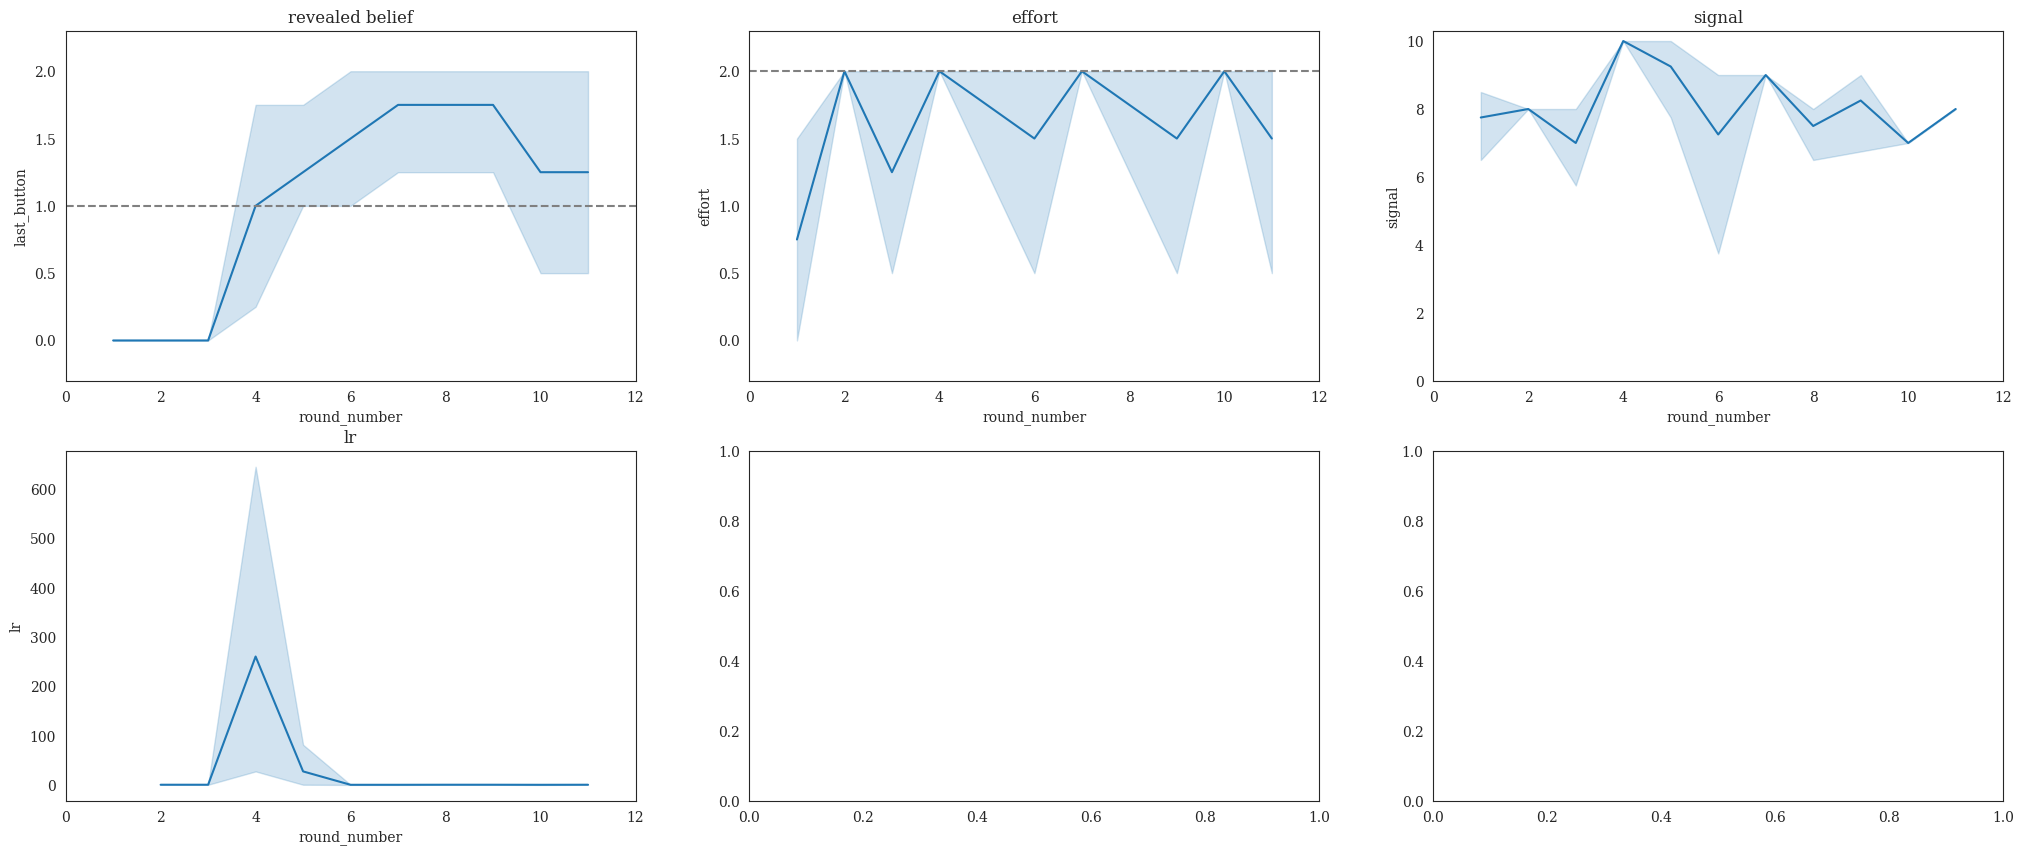

In [722]:
# The paths whith the 4 highest values of lr (above 50)

fig, axs = plt.subplots(2, 3, figsize=(25, 10))

sns.lineplot(data=abnormals, x='round_number', y='last_button', ax=axs[0,0])
axs[0,0].set_title('revealed belief')
sns.lineplot(data=abnormals, x='round_number', y='effort', ax=axs[0,1])
axs[0,1].set_title('effort')
sns.lineplot(data=abnormals, x='round_number', y='signal', ax=axs[0,2])
axs[0,2].set_title('signal')
sns.lineplot(data=abnormals, x='round_number', y='lr', ax=axs[1,0])
axs[1,0].set_title('lr')

axs[0, 0].set_ylim((-0.3, 2.3))
axs[0, 1].set_ylim((-0.3, 2.3))
axs[0, 2].set_ylim((0, 10.3))


axs[0, 0].set_xlim((0, 12))
axs[0, 1].set_xlim((0, 12))
axs[0, 2].set_xlim((0, 12))
axs[1, 0].set_xlim((0, 12))

axs[0, 0].axhline(y=abnormals['theta'].mean(), linestyle='--', color='gray')
axs[0, 1].axhline(y=abnormals['omega'].mean(), linestyle='--', color='gray')

Text(0.5, 1.0, 'Switching Threshold by topic')

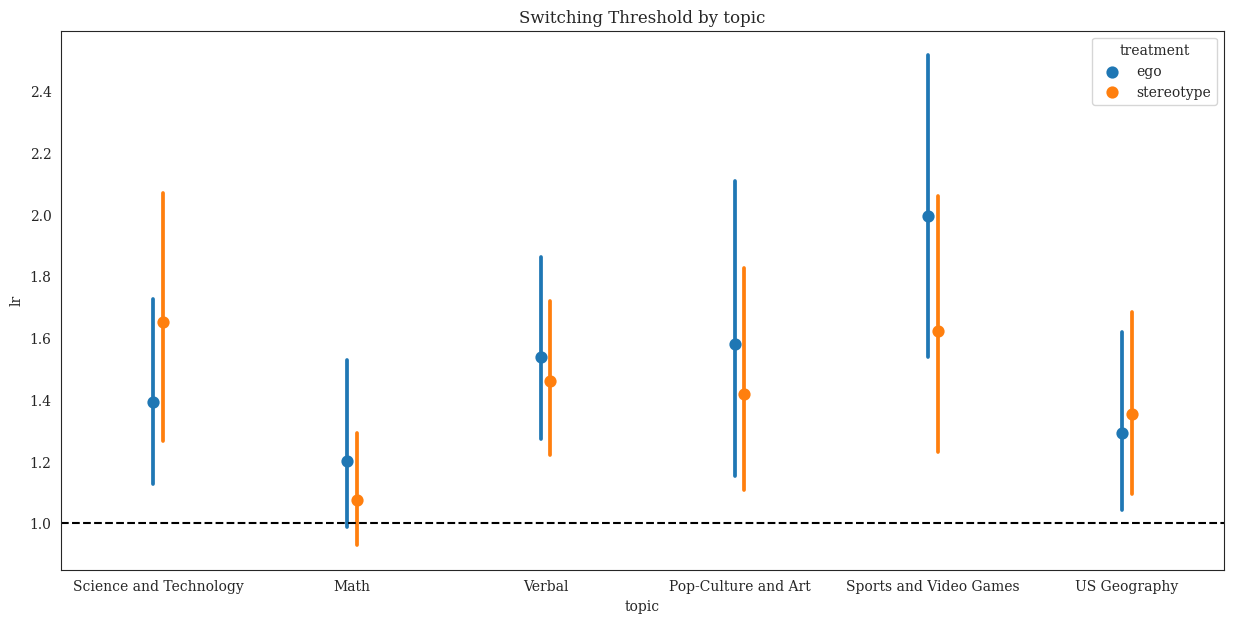

In [723]:
# plot the estimates of alpha by topic
axs, fig = plt.subplots(1,1, figsize=(15, 7))
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['lr']<15)], 
              y='lr', x='topic', join =False, hue='treatment', dodge=True)

plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by topic')


# Add the simulation data and reshape to merge to the experiment's data

In [724]:
# import the simulation data
sim = pd.read_csv("../Simulations/demo/data/simulation.csv")

In [725]:
updates['topic'].unique()

array(['Science and Technology', 'Math', 'Verbal', 'Pop-Culture and Art',
       'Sports and Video Games', 'US Geography'], dtype=object)

In [726]:
# split the data by initial belief and add the relevant simulations given the initial belief and the true omega and theta
initial_L = updates.loc[updates['belief']==0]
initial_M = updates.loc[updates['belief']==1]
initial_H = updates.loc[updates['belief']==2]




In [727]:
# adjust the round numbers from the simulation to match the data (get rif od rounf 0 of the simulation, it was just the starting parameters)
sim['round_number_modif'] = sim['round_number']+1
sim['round_number_modif'] = sim['round_number_modif'].astype(int)

# split the simulations by initial beliefs
sim_L = sim[['e_lr_L', 'e_dog_L', 'e_bay', 'e_ss', 'e_joint', 'e_joint_ss', 'theta_lr_L', 'theta', 'omega', 'round_number_modif']]
sim_M = sim[['e_lr_M', 'e_dog_M', 'e_bay', 'e_ss', 'e_joint','e_joint_ss', 'theta_lr_M', 'theta', 'omega', 'round_number_modif']]
sim_H = sim[['e_lr_H', 'e_dog_H', 'e_bay', 'e_ss', 'e_joint', 'e_joint_ss', 'theta_lr_H', 'theta', 'omega', 'round_number_modif']]



In [728]:
sim_L = sim_L.rename(columns={'e_lr_L':'switcher', 
                      'e_dog_L':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind',
                      'e_joint':'bayesian',
                      'e_joint_ss':'self-serving', 
                      'theta_lr_L':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_M = sim_M.rename(columns={'e_lr_M':'switcher', 
                      'e_dog_M':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind', 
                      'e_joint':'bayesian',
                      'e_joint_ss':'self-serving',
                      'theta_lr_M':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_H = sim_H.rename(columns={'e_lr_H':'switcher', 
                      'e_dog_H':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind', 
                      'e_joint':'bayesian',
                      'e_joint_ss':'self-serving',
                      'theta_lr_H':'switcher_belief',
                      'round_number_modif':'round_number'})

In [729]:
sim_L['belief'] = 0
sim_M['belief'] = 1
sim_H['belief'] = 2

In [730]:
sim = pd.concat([sim_L, sim_M, sim_H])

In [731]:
# merge with the update data on the round number, the belief and the theta and omega. 
updates = updates.merge(sim, on=['round_number', 'belief', 'theta', 'omega'], how='left')

# The Simulations

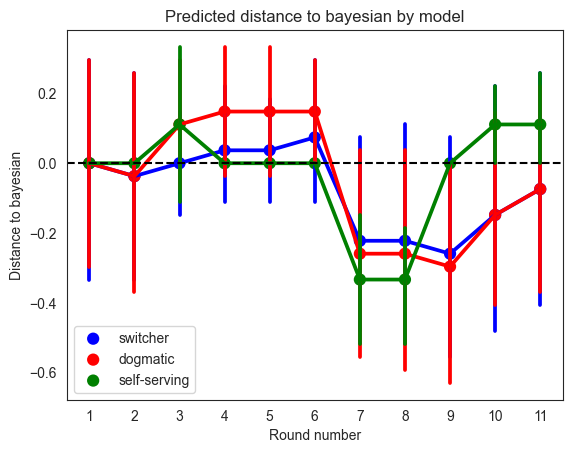

In [732]:
# compare the simulations to the bayesian simulation by taking the distance from each of the simulations to the bayesian simulation
# and then plot all of them
# first take the distance from switcher to bayesian
sim['switcher_bayesian'] = sim['switcher'] - sim['bayesian']
# then take the distance from dogmatic to bayesian
sim['dogmatic_bayesian'] = sim['dogmatic'] - sim['bayesian']
# then take the distance from self-serving to bayesian
sim['self-serving_bayesian'] = sim['self-serving'] - sim['bayesian']

# plot each of the distances as a line in the same plot
sns.set_style("white")
sns.pointplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
sns.pointplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
sns.pointplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Distance to bayesian')
plt.xlabel('Round number')
plt.title('Predicted distance to bayesian by model')
plt.legend()

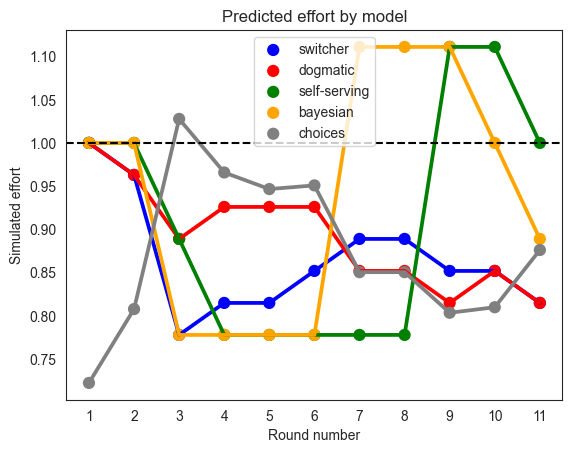

In [733]:
# plot each of the simulations as a line in the same plot
sns.set_style("white")
sns.pointplot(data=sim, x='round_number', y='switcher', label='switcher', color='blue', errorbar=None)
sns.pointplot(data=sim, x='round_number', y='dogmatic', label='dogmatic', color='red', errorbar=None)
sns.pointplot(data=sim, x='round_number', y='self-serving', label='self-serving', color='green', errorbar=None)
sns.pointplot(data=sim, x='round_number', y='bayesian', label='bayesian', color='orange', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='effort', label='choices', color='gray', errorbar=None)

# add a horizontal line at  the average omega
plt.axhline(y=sim['omega'].mean(), color='black', linestyle='--')
plt.ylabel('Simulated effort')
plt.xlabel('Round number')
plt.title('Predicted effort by model')
plt.legend()


In [734]:
# add a column called misspecification to the data frame sim which is -1 if belief is lower than theta, 0 if they are the same and 1 if belief is higher than theta
sim.loc[sim['switcher_belief']<sim['theta'], 'misspecification'] = -1
sim.loc[sim['switcher_belief']==sim['theta'], 'misspecification'] = 0
sim.loc[sim['switcher_belief']>sim['theta'], 'misspecification'] = 1

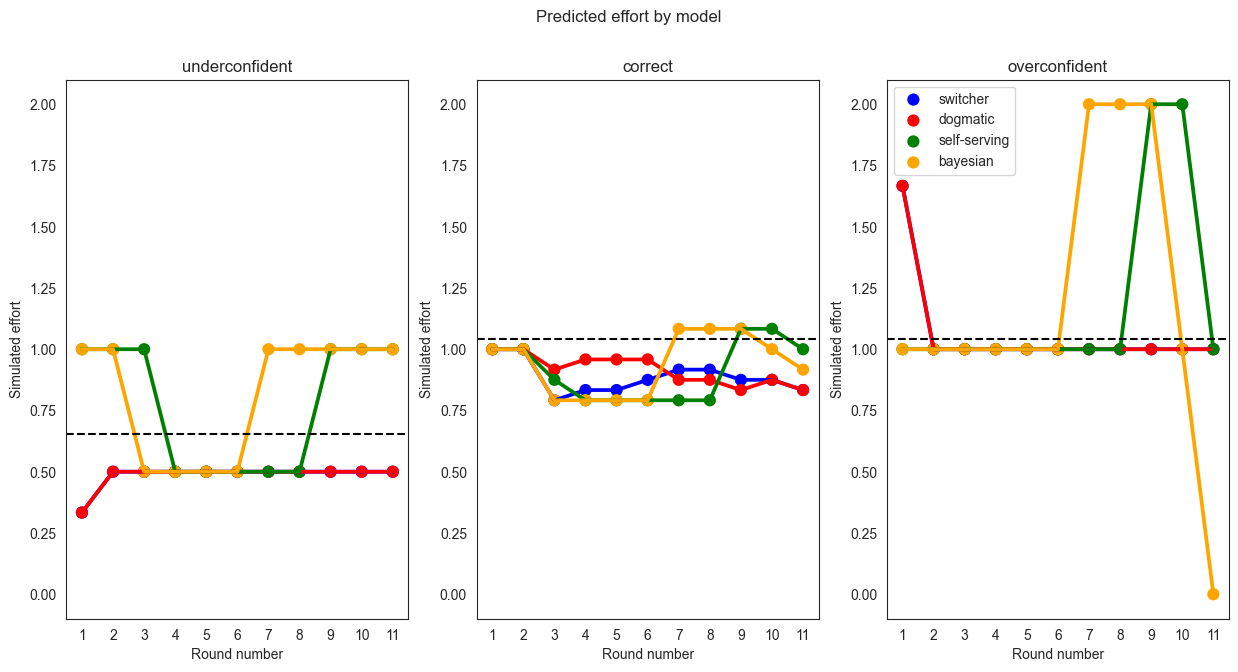

In [735]:
# plot the predictions of each model in the case of over confidence, correct and under confidence
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('Predicted effort by model')
# plot each of the simulations as a line in the same plot
sns.set_style("white")
sns.pointplot(data=sim[sim['misspecification']==-1], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[0], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==-1], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[0], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==-1], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[0], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==-1], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[0], errorbar=None)

# add a horizontal line at  the average omega
axs[0].axhline(y=sim.loc[sim['misspecification']==-1, 'omega'].mean(), color='black', linestyle='--')
axs[0].set_ylabel('Simulated effort')
axs[0].set_xlabel('Round number')
axs[0].set_title('underconfident')
axs[0].set_ylim(-.1, 2.1)


sns.set_style("white")
sns.pointplot(data=sim[sim['misspecification']==0], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[1], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==0], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[1], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==0], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[1], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==0], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[1], errorbar=None)

# add a horizontal line at  the average omega
axs[1].axhline(y=sim.loc[sim['misspecification']==0, 'omega'].mean(), color='black', linestyle='--')
axs[1].set_ylabel('Simulated effort')
axs[1].set_xlabel('Round number')
axs[1].set_title('correct')
axs[1].set_ylim(-.1, 2.1)


sns.set_style("white")
sns.pointplot(data=sim[sim['misspecification']==1], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[2], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==1], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[2], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==1], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[2], errorbar=None)
sns.pointplot(data=sim[sim['misspecification']==1], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[2], errorbar=None)

# add a horizontal line at  the average omega
axs[2].axhline(y=sim.loc[sim['misspecification']==0, 'omega'].mean(), color='black', linestyle='--')
axs[2].set_ylabel('Simulated effort')
axs[2].set_xlabel('Round number')
axs[2].set_title('overconfident')
axs[2].set_ylim(-.1, 2.1)

axs[2].legend()

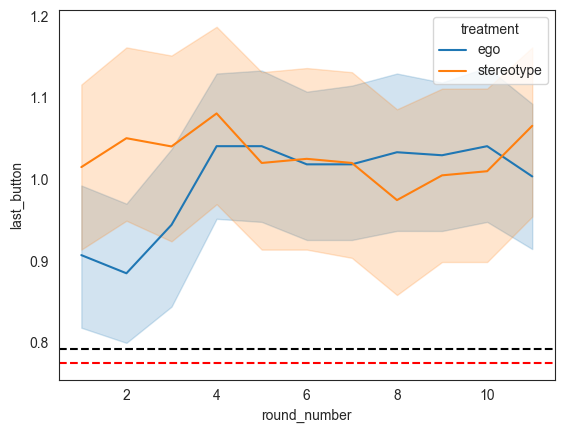

In [736]:
# tracking the last button
sns.lineplot(data=updates, x='round_number', y='last_button', hue='treatment')
avg_type = np.mean(updates['theta'])
avg_belief = np.mean(updates['belief'])
plt.axhline(y=avg_type, color='black', linestyle='--', label='average theta')
plt.axhline(y=avg_belief, color='red', linestyle='--', label='average belief') 


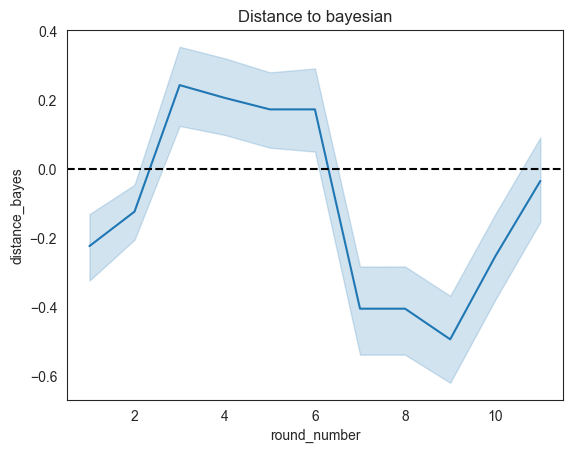

In [737]:
# compute the distance between the observed effort choices and what a bayesian agent would have done
updates['distance_bayes'] = updates['effort']- updates['bayesian']

# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_bayes')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Distance to bayesian')

plt.savefig('../figures/distance_bayes.png', dpi=300)

## Do the plots for each case of misspecification separately. 


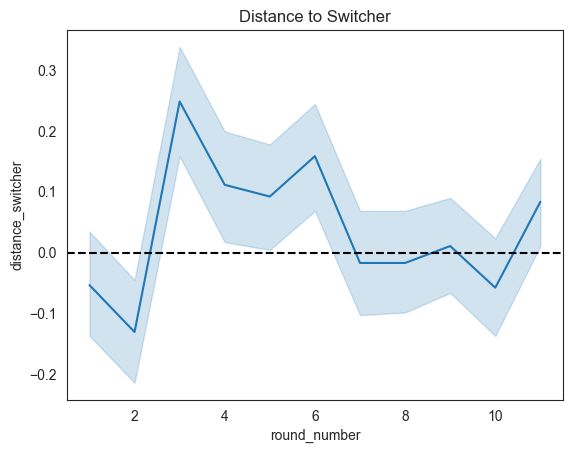

In [738]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher'] = updates['effort'] - updates['switcher']
updates['distance_dogmatic'] = updates['effort'] - updates['dogmatic']
updates['distance_bayesian'] = updates['effort'] - updates['bayesian']
updates['distance_self-serving'] = updates['effort'] - updates['self-serving']

# plot the distance over rounds for each of the MODES

# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_switcher')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher')
plt.savefig('../figures/distance_switcher.png')

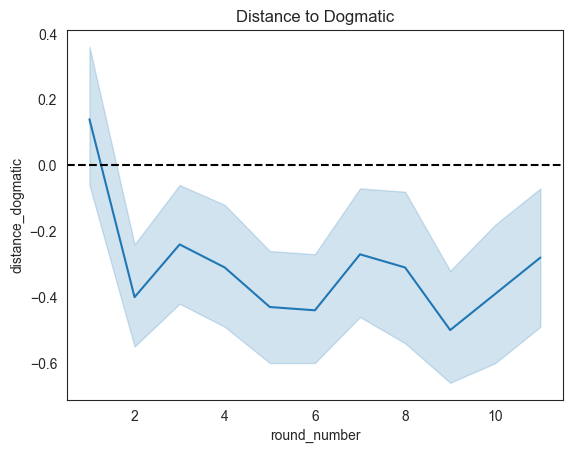

In [739]:
# the dogmatic model only applies to a subset of cases. I take only those in a different data frame called dogmatic_updates
dogmatic_updates = updates[(updates['theta']==0) & (updates['omega']==2) & (updates['belief']==1)|
                           (updates['theta']==1) & (updates['omega']==0) & (updates['belief']==0)|
                           (updates['theta']==1) & (updates['omega']==1) & (updates['belief']==0)|
                           (updates['theta']==1) & (updates['omega']==1) & (updates['belief']==2)|
                           (updates['theta']==1) & (updates['omega']==2) & (updates['belief']==2)|
                           (updates['theta']==2) & (updates['omega']==1) & (updates['belief']==1)]

# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic')

plt.savefig('../figures/distance_dogmatic.png')

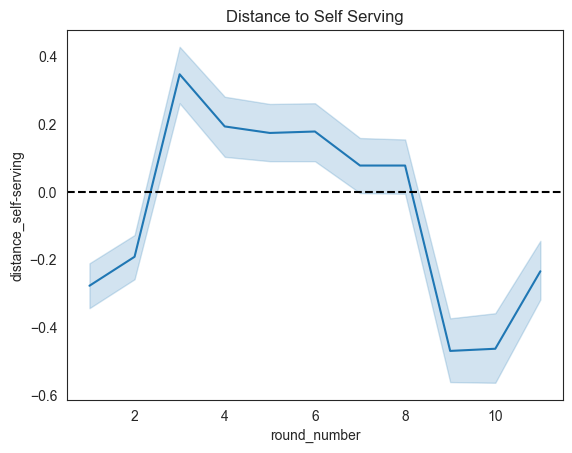

In [740]:
# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving')

plt.savefig('../figures/distance_self-serving.png')

In [741]:
# create a function that takes in theta and omega and the data and returns 8 plots
def plot(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0])
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1])
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [742]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot(updates, t, o)
        plt.savefig('../figures/updates_'+str(t)+str(o)+'.png')
        plt.close()

In [743]:
# create a function that takes in theta and omega and the data and returns 8 plots and plots each treatment separately
def plot_treatment(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [744]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot_treatment(updates, t, o)
        plt.savefig('../figures/updates_by_treatment'+str(t)+str(o)+'.png')
        plt.close()

# Try to Classify subjects based on their behavior

In [745]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'last_button_consistent', 'last_button_correct', 'treatment_indic',
       'interaction', 'topic_num', 'player_code', 'current_belief_start',
       'belief_change', 'change_indicator', 'change_indicator_sum', 'lr',
       'log_lr', 'switcher', 'dogmatic', 'bayesian_ind', 'self-serving_ind',
       'bayesian', 'self-serving', 'switcher_belief', 'distance_bayes',
       'distance_switcher', 'distance_dogmatic', 'distance_bayesian',
       'distance_self-serving'],
      dtype='object')

In [746]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher_abs'] = np.abs(updates['effort'] - updates['switcher'])
updates['distance_dogmatic_abs'] = np.abs(updates['effort'] - updates['dogmatic'])
updates['distance_bayesian_abs'] = np.abs(updates['effort'] - updates['bayesian'])
updates['distance_self-serving_abs'] = np.abs(updates['effort'] - updates['self-serving'])

# create a new data set with the sum the computed distences by player_code for each of the models
distances = pd.DataFrame()
distances['distance_switcher_sum'] = updates.groupby('code')['distance_switcher_abs'].sum()
distances['distance_dogmatic_sum'] = updates.groupby('code')['distance_dogmatic_abs'].sum()
distances['distance_bayesian_sum'] = updates.groupby('code')['distance_bayesian_abs'].sum()
distances['distance_self-serving_sum'] = updates.groupby('code')['distance_self-serving_abs'].sum()

# for each player_code, return the model that has the smallest sum
distances['best_model'] = np.argmin(distances[['distance_switcher_sum', 'distance_dogmatic_sum', 'distance_bayesian_sum', 'distance_self-serving_sum']].values, axis=1)

# merge with the updates data 
updates = updates.merge(distances, on='code', how='left')

In [747]:
# make a data frame with the average distances by subject.
subject_models=updates.groupby(['code', 'treatment']).mean('best_model')
subject_models.reset_index(inplace=True)


In [748]:
# for each subject, take the average distance of the best fittig model and set it in a new column
subject_models.loc[subject_models['best_model']==0, 'min_distance'] = subject_models.loc[subject_models['best_model']==0, 'distance_switcher_sum']
subject_models.loc[subject_models['best_model']==1, 'min_distance'] = subject_models.loc[subject_models['best_model']==1, 'distance_dogmatic_sum']
subject_models.loc[subject_models['best_model']==2, 'min_distance'] = subject_models.loc[subject_models['best_model']==2, 'distance_bayesian_sum']
subject_models.loc[subject_models['best_model']==3, 'min_distance'] = subject_models.loc[subject_models['best_model']==3,'distance_self-serving_sum']


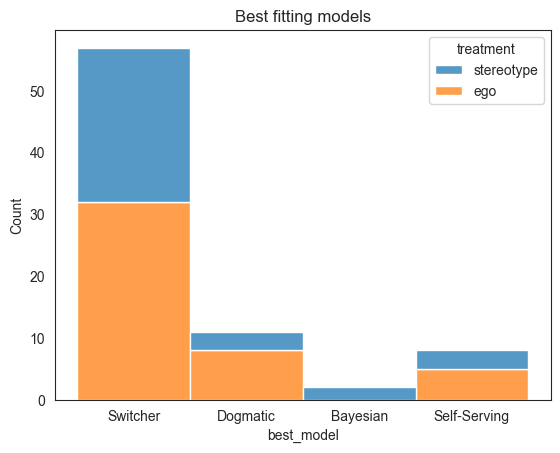

In [749]:
#count the number of subjects for which each of the models id the best fitting among all 4 of them
sns.histplot(data=subject_models, x='best_model', discrete=True, hue='treatment', multiple='stack')
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.title('Best fitting models')
plt.savefig('../figures/model_fit_histogram.png')

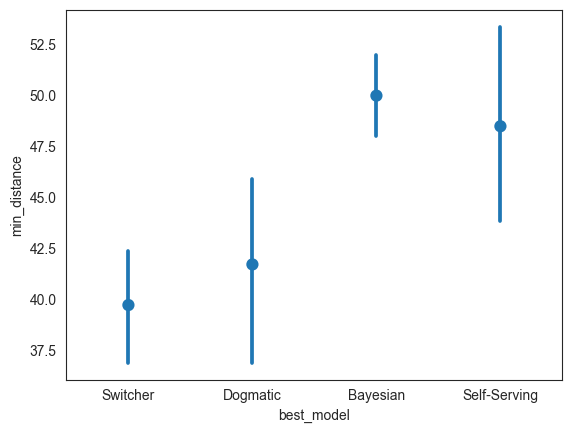

In [750]:
# plot the average minimal distance for each of the models
sns.pointplot(data=subject_models, x='best_model', y='min_distance', join =False)
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.savefig('../figures/model_min_distance.png')

In [751]:
# for each code, count the number of times that distance_switcher_abs takes the value cero and 
# include it in a column called switcher_correct
updates['switcher_correct'] = np.where(updates['distance_switcher_abs']==0, 1, 0)

# Is treatment different from control?
Do they abandon misspecified beliefs faster in the steroetype treatment?
Are misspecifications more or less common

Is the classification different in the two treatments?

Is alpha different in treatment than in control?

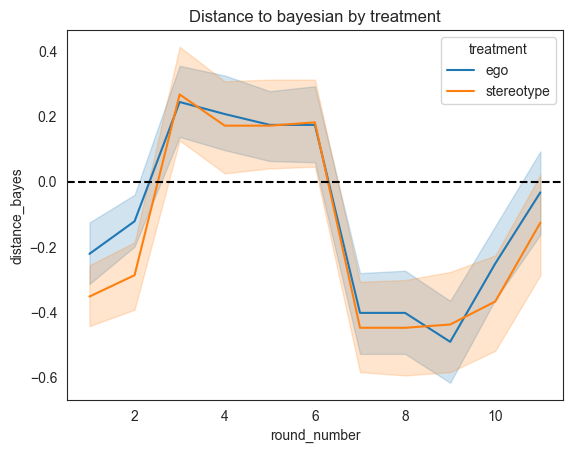

In [752]:
# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_bayes', hue='treatment')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Distance to bayesian by treatment') 

plt.savefig('../figures/distance_bayes_treatment.png')

<function matplotlib.pyplot.legend(*args, **kwargs)>

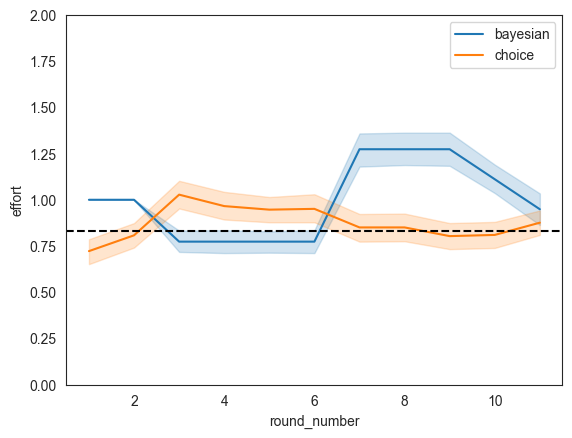

In [753]:
sns.lineplot(data=updates, x='round_number', y='bayesian', label='bayesian')
sns.lineplot(data=updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylim(0, 2)
plt.ylabel('effort')
plt.legend

(0.0, 2.0)

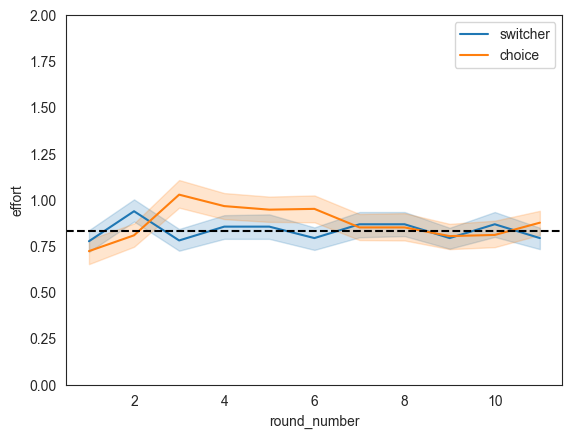

In [754]:
sns.lineplot(data=updates, x='round_number', y='switcher', label='switcher')
sns.lineplot(data=updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylabel('effort')
plt.legend()
plt.ylim(0, 2)

(0.0, 2.0)

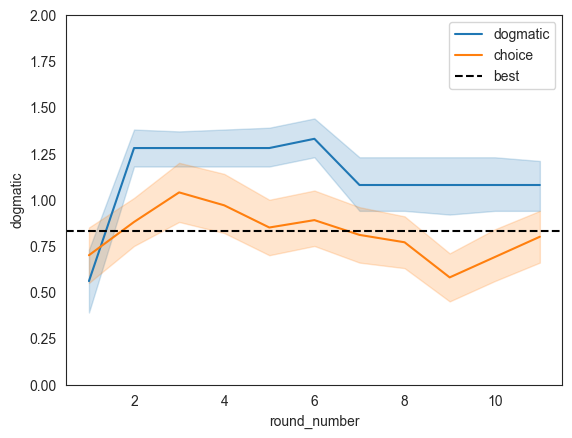

In [755]:
sns.lineplot(data=dogmatic_updates, x='round_number', y='dogmatic', label='dogmatic')
sns.lineplot(data=dogmatic_updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--', label='best')
plt.legend()
plt.ylim(0, 2)

(0.0, 2.0)

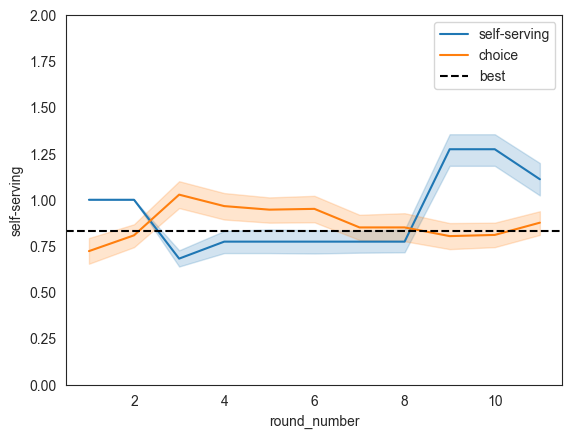

In [756]:
sns.lineplot(data=updates, x='round_number', y='self-serving', label='self-serving')
sns.lineplot(data=updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--', label='best')

plt.legend()
plt.ylim(0, 2)

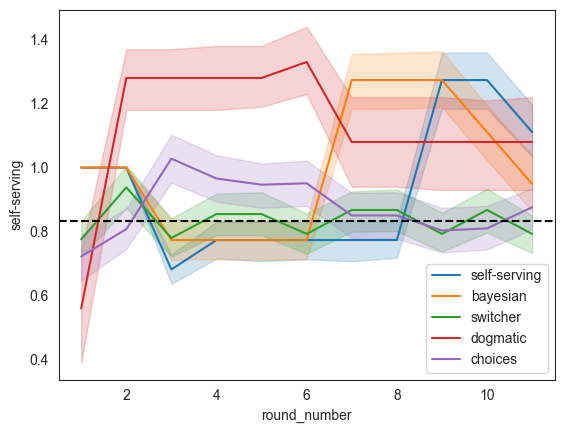

In [757]:
sns.lineplot(data=updates, x='round_number', y='self-serving', label='self-serving')
sns.lineplot(data=updates, x='round_number', y='bayesian', label='bayesian')
sns.lineplot(data=updates, x='round_number', y='switcher', label='switcher')
sns.lineplot(data=dogmatic_updates, x='round_number', y='dogmatic', label='dogmatic')
sns.lineplot(data=updates, x='round_number', y='effort', label='choices')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--', label='best')

Text(0.5, 1.0, 'high omega')

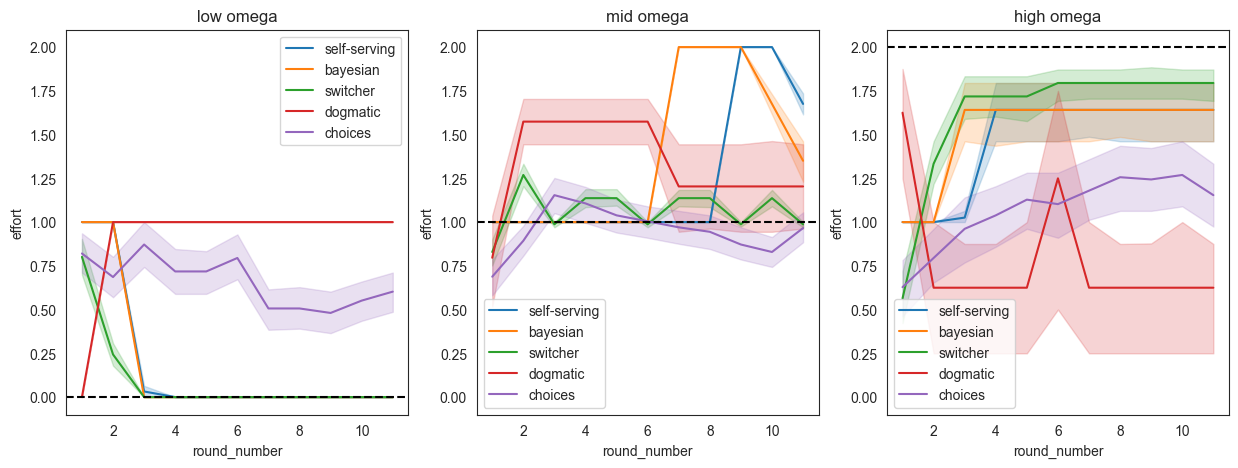

In [758]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(data=updates[updates['omega']==0], x='round_number', y='self-serving', label='self-serving', ax=axs[0])
sns.lineplot(data=updates[updates['omega']==0], x='round_number', y='bayesian', label='bayesian', ax=axs[0])
sns.lineplot(data=updates[updates['omega']==0], x='round_number', y='switcher', label='switcher', ax=axs[0])
sns.lineplot(data=dogmatic_updates[dogmatic_updates['omega']==0], x='round_number', y='dogmatic', label='dogmatic', ax=axs[0])
sns.lineplot(data=updates[updates['omega']==0], x='round_number', y='effort', label='choices', ax=axs[0])
# add a line with the average omega
axs[0].axhline(y=0, color='black', linestyle='--', label='best')
axs[0].set_ylim(-0.1, 2.1)
axs[0].set_ylabel('effort')
axs[0].set_title('low omega')

sns.lineplot(data=updates[updates['omega']==1], x='round_number', y='self-serving', label='self-serving', ax=axs[1])
sns.lineplot(data=updates[updates['omega']==1], x='round_number', y='bayesian', label='bayesian', ax=axs[1])
sns.lineplot(data=updates[updates['omega']==1], x='round_number', y='switcher', label='switcher', ax=axs[1])
sns.lineplot(data=dogmatic_updates[dogmatic_updates['omega']==1], x='round_number', y='dogmatic', label='dogmatic', ax=axs[1])
sns.lineplot(data=updates[updates['omega']==1], x='round_number', y='effort', label='choices', ax=axs[1])
# add a line with the average omega
axs[1].axhline(y=1, color='black', linestyle='--', label='best')
axs[1].set_ylim(-.1, 2.1)
axs[1].set_ylabel('effort')
axs[1].set_title('mid omega')

sns.lineplot(data=updates[updates['omega']==2], x='round_number', y='self-serving', label='self-serving', ax=axs[2])
sns.lineplot(data=updates[updates['omega']==2], x='round_number', y='bayesian', label='bayesian', ax=axs[2])
sns.lineplot(data=updates[updates['omega']==2], x='round_number', y='switcher', label='switcher', ax=axs[2])
sns.lineplot(data=dogmatic_updates[dogmatic_updates['omega']==2], x='round_number', y='dogmatic', label='dogmatic', ax=axs[2])
sns.lineplot(data=updates[updates['omega']==2], x='round_number', y='effort', label='choices', ax=axs[2])
# add a line with the average omega
axs[2].axhline(y=2, color='black', linestyle='--', label='best')
axs[2].set_ylim(-.1, 2.1)
axs[2].set_ylabel('effort')
axs[2].set_title('high omega')

Text(0.5, 1.0, 'high omega')

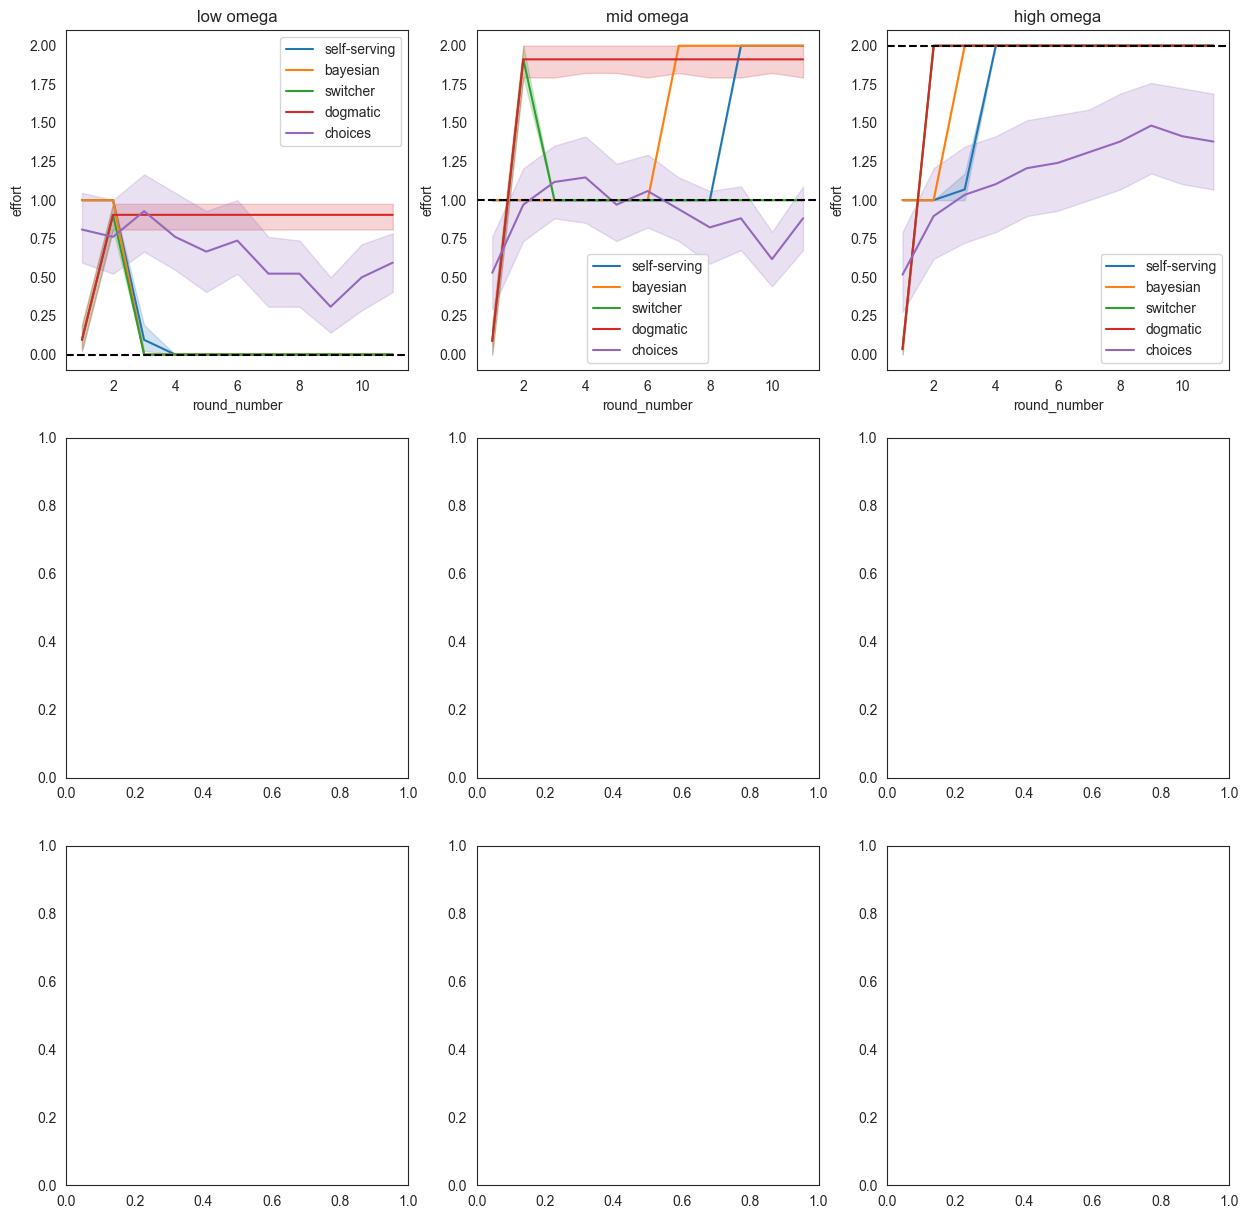

In [759]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
sns.lineplot(data=updates[(updates['omega']==0) & (updates['misspecification']=='under')], x='round_number', y='self-serving', label='self-serving', ax=axs[0,0])
sns.lineplot(data=updates[(updates['omega']==0) & (updates['misspecification']=='under')], x='round_number', y='bayesian', label='bayesian', ax=axs[0, 0])
sns.lineplot(data=updates[(updates['omega']==0) & (updates['misspecification']=='under')], x='round_number', y='switcher', label='switcher', ax=axs[0, 0])
sns.lineplot(data=updates[(updates['omega']==0) & (updates['misspecification']=='under')], x='round_number', y='dogmatic', label='dogmatic', ax=axs[0, 0])
sns.lineplot(data=updates[(updates['omega']==0) & (updates['misspecification']=='under')], x='round_number', y='effort', label='choices', ax=axs[0, 0])
# add a line with the average omega
axs[0, 0].axhline(y=0, color='black', linestyle='--', label='best')
axs[0, 0].set_ylim(-0.1, 2.1)
axs[0, 0].set_ylabel('effort')
axs[0, 0].set_title('low omega')

sns.lineplot(data=updates[(updates['omega']==1) & (updates['misspecification']=='under')], x='round_number', y='self-serving', label='self-serving', ax=axs[0, 1])
sns.lineplot(data=updates[(updates['omega']==1) & (updates['misspecification']=='under')], x='round_number', y='bayesian', label='bayesian', ax=axs[0, 1])
sns.lineplot(data=updates[(updates['omega']==1) & (updates['misspecification']=='under')], x='round_number', y='switcher', label='switcher', ax=axs[0, 1])
sns.lineplot(data=updates[(updates['omega']==1) & (updates['misspecification']=='under')], x='round_number', y='dogmatic', label='dogmatic', ax=axs[0, 1])
sns.lineplot(data=updates[(updates['omega']==1) & (updates['misspecification']=='under')], x='round_number', y='effort', label='choices', ax=axs[0, 1])
# add a line with the average omega
axs[0, 1].axhline(y=1, color='black', linestyle='--', label='best')
axs[0, 1].set_ylim(-.1, 2.1)
axs[0, 1].set_ylabel('effort')
axs[0, 1].set_title('mid omega')

sns.lineplot(data=updates[(updates['omega']==2) & (updates['misspecification']=='under')], x='round_number', y='self-serving', label='self-serving', ax=axs[0, 2])
sns.lineplot(data=updates[(updates['omega']==2) & (updates['misspecification']=='under')], x='round_number', y='bayesian', label='bayesian', ax=axs[0, 2])
sns.lineplot(data=updates[(updates['omega']==2) & (updates['misspecification']=='under')], x='round_number', y='switcher', label='switcher', ax=axs[0, 2])
sns.lineplot(data=updates[(updates['omega']==2) & (updates['misspecification']=='under')], x='round_number', y='dogmatic', label='dogmatic', ax=axs[0, 2])
sns.lineplot(data=updates[(updates['omega']==2) & (updates['misspecification']=='under')], x='round_number', y='effort', label='choices', ax=axs[0, 2])
# add a line with the average omega
axs[0, 2].axhline(y=2, color='black', linestyle='--', label='best')
axs[0, 2].set_ylim(-.1, 2.1)
axs[0, 2].set_ylabel('effort')
axs[0, 2].set_title('high omega')

(-1.0, 1.0)

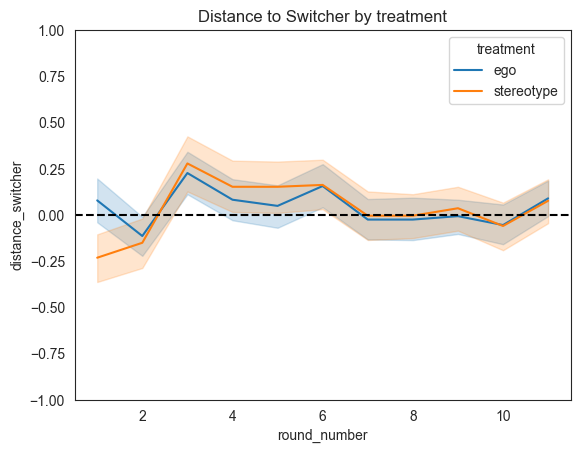

In [760]:
# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_switcher', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher by treatment')
plt.savefig('../figures/distance_switcher_treatment.png')

plt.ylim(-1, 1)

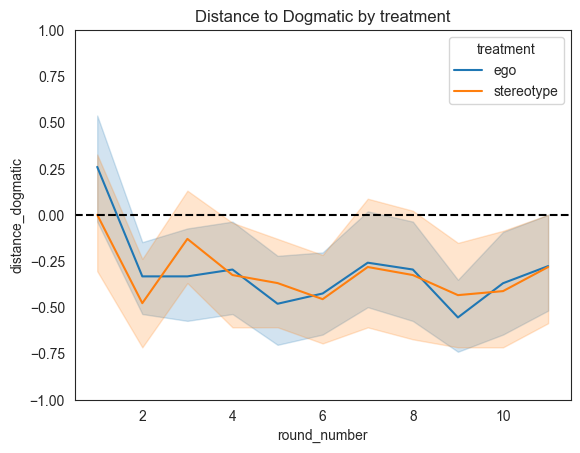

In [761]:
# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic by treatment')
plt.ylim(-1, 1)

plt.savefig('../figures/distance_dogmatic_treatment.png')


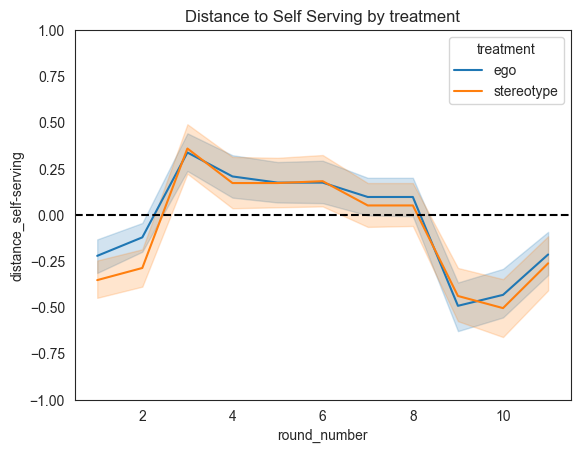

In [762]:

# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving by treatment')
plt.ylim(-1, 1)

plt.savefig('../figures/distance_self-serving_treatment.png')

### T-tests
test if the difference between the observed data and the simulations are different from cero and order them from best fit to worst fit.
plot points with confidence intervals

# What are the characterising features of the subjects that are misspecified?
Do are misspecified subjects more likely to attribute it to others?

## Try to estimate parameters for Self-Attribution bias

In [763]:
updates['certainty']= updates['certainty']/100

# Differences across topics

<Axes: xlabel='misspecification', ylabel='Probability'>

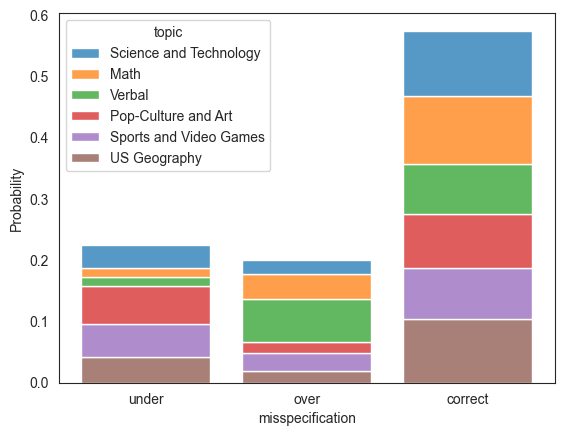

In [764]:
sns.histplot(data=updates, x='misspecification', hue='topic', multiple='stack', stat='probability', shrink=.8, discrete=True)

<Axes: xlabel='misspecification', ylabel='certainty'>

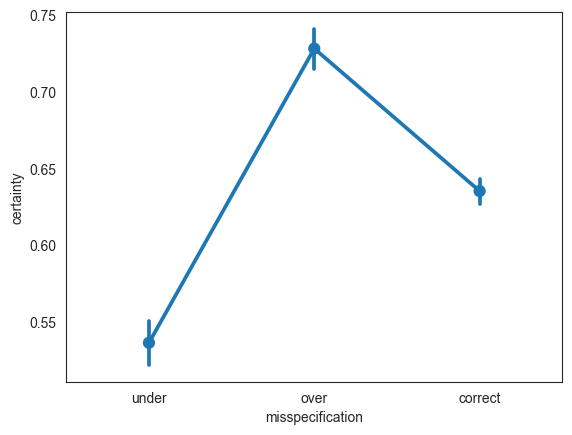

In [765]:
sns.pointplot(data=updates, x='misspecification', y='certainty')

<Axes: xlabel='theta', ylabel='Probability'>

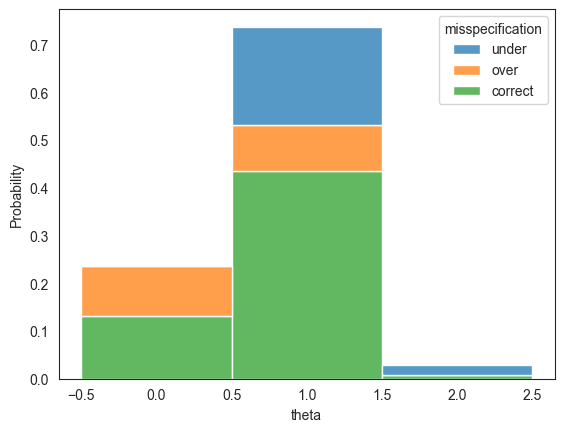

In [766]:
# their beliefs by score
sns.histplot(data=updates, x='theta', hue='misspecification', multiple='stack', discrete=True, stat='probability')

In [767]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'last_button_consistent', 'last_button_correct', 'treatment_indic',
       'interaction', 'topic_num', 'player_code', 'current_belief_start',
       'belief_change', 'change_indicator', 'change_indicator_sum', 'lr',
       'log_lr', 'switcher', 'dogmatic', 'bayesian_ind', 'self-serving_ind',
       'bayesian', 'self-serving', 'switcher_belief', 'distance_bayes',
       'distance_switcher', 'distance_dogmatic', 'distance_bayesian',
       'distance_self-serving', 'distance_switcher_abs',
       'distance_dogmatic_abs', 'distance_bayesian_abs',
       'distance_self-serving_abs', 'distance_switcher_sum',
       'distance_dogmatic_sum', 'distance_bayesian_sum',
       'distance_self-serving_sum'

Text(0.5, 0.98, 'Misspecification by treatment in first and last round')

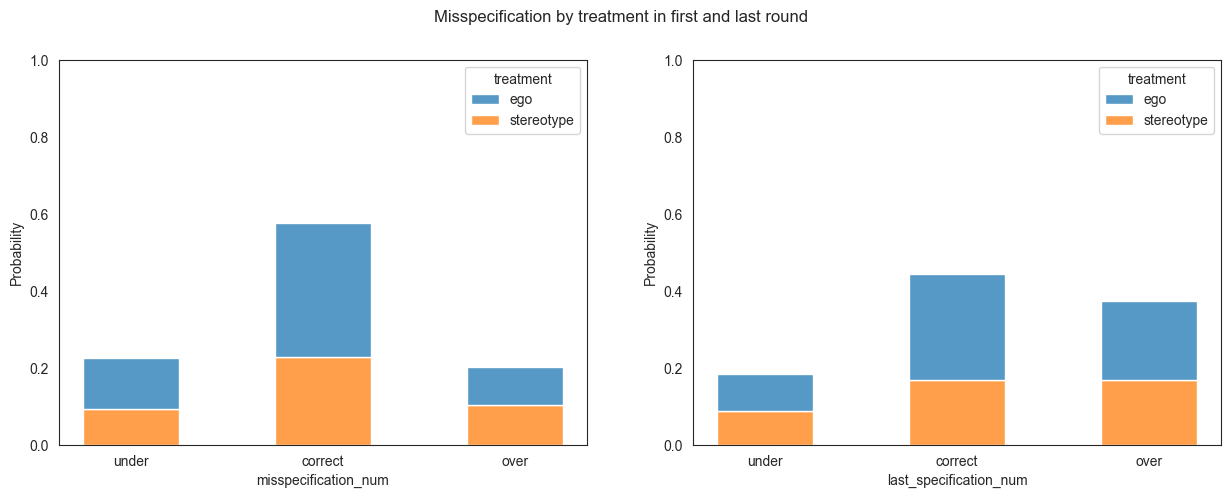

In [768]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=round_1, x='misspecification_num', hue='treatment', discrete=True, stat='probability', shrink=.5, multiple='stack', ax=axs[0])
axs[0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0].set_ylim(0, 1)
sns.histplot(data=round_11, x='last_specification_num', hue='treatment', discrete=True, stat='probability', shrink=.5, multiple='stack', ax=axs[1])
axs[1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1].set_ylim(0, 1)

fig.suptitle('Misspecification by treatment in first and last round')


## Consistency in matrix choices

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_94339/4212933325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1['consistent_first']=round_1['belief']==round_1['last_button']
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


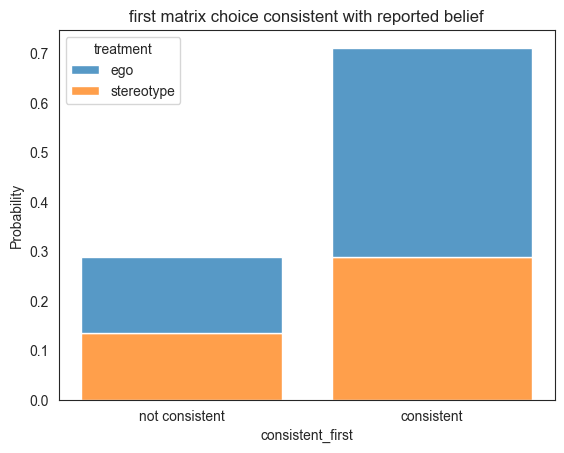

In [769]:
# check if the fist matrix that they choose to see matches the belief they reported
# create a data frame with only round 1
round_1 = updates.loc[updates['round_number']==1, :]

# create a column that indicates whether the last_button in round 1 matches the reported belief
round_1['consistent_first']=round_1['belief']==round_1['last_button']

np.mean(round_1['consistent_first'])

sns.histplot(data=round_1, x='consistent_first', hue='treatment', multiple='stack', 
             discrete=True, stat='probability', shrink=.8)
plt.title('first matrix choice consistent with reported belief')
plt.xticks([0, 1], ['not consistent', 'consistent'])

plt.savefig('../figures/consistency_first.png')

### The Subjects who never changed the matrix choice

Text(0.5, 1.0, 'Best fitting models')

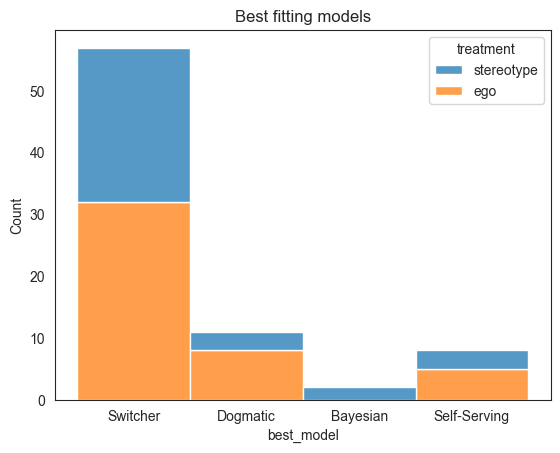

In [770]:
#count the number of subjects for which each of the models id the best fitting among all 4 of them
sns.histplot(data=subject_models, x='best_model', discrete=True, hue='treatment', multiple='stack')
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.title('Best fitting models')


Text(0.5, 1.0, 'Distance to Best fitting models')

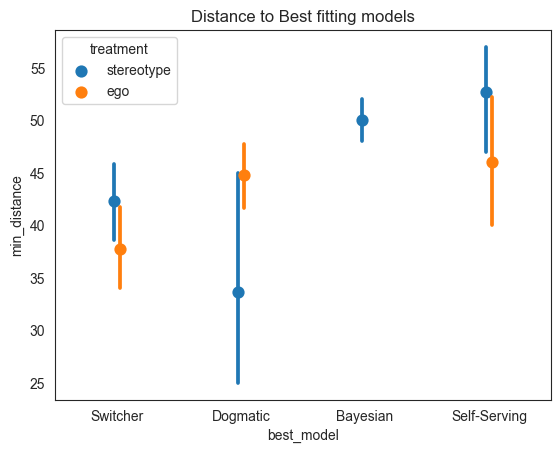

In [771]:
# plot the distance to each of the models by treatment in a point plot
sns.pointplot(data=subject_models, x='best_model', y='min_distance', join=False, hue='treatment', dodge=True)
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.title('Distance to Best fitting models')

## Choices relative to the optimal

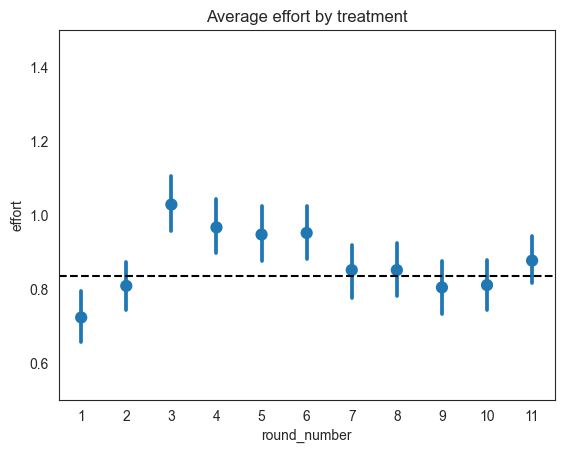

In [772]:
# do a point plot with the average effort by treatment. 
sns.pointplot(data=updates, x='round_number', y='effort', join =False)
plt.title('Average effort by treatment')
# plot a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylim(0.5, 1.5)
plt.savefig('../figures/effort_by_treatment.png')

Text(0.5, 1.0, 'Average effort by treatment')

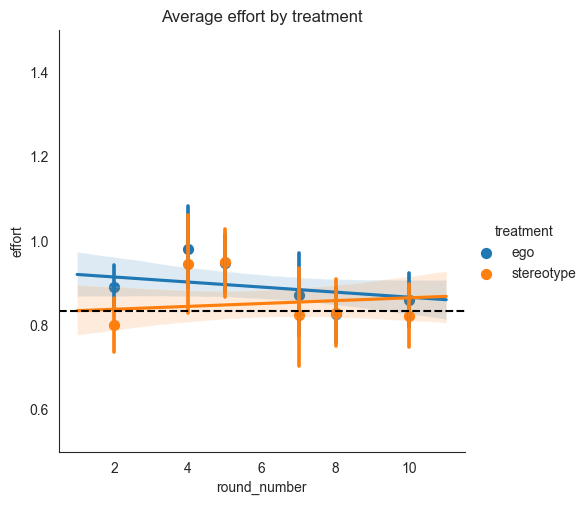

In [773]:
sns.lmplot(data=updates, x='round_number', y='effort', x_bins=6, hue='treatment')
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylim(0.5, 1.5)
plt.title('Average effort by treatment')


Text(0.5, 1.0, 'effort by round, rate = 0')

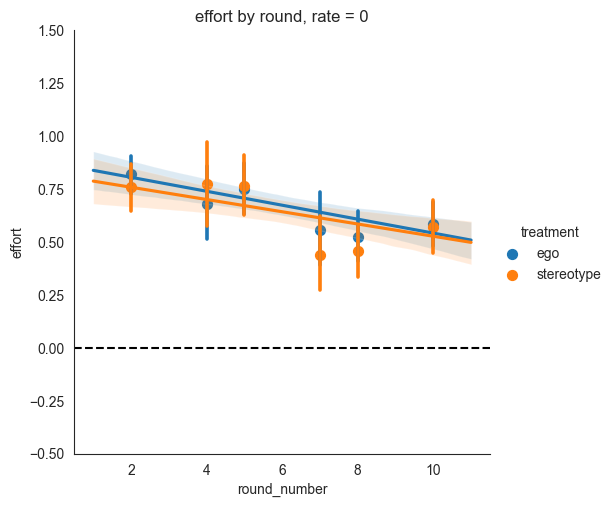

In [774]:
sns.lmplot(data=updates[updates['omega']==0], x='round_number', y='effort', x_bins=6, hue='treatment')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-0.5, 1.5)
plt.title('effort by round, rate = 0')

Text(0.5, 1.0, 'belief by round, rate = 0')

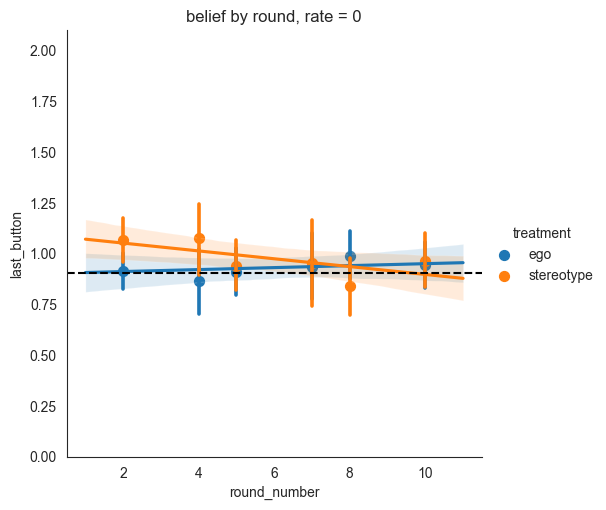

In [775]:
sns.lmplot(data=updates[updates['omega']==0], x='round_number', y='last_button', x_bins=6, hue='treatment')
plt.axhline(y=updates.loc[updates['omega']==0, 'theta'].mean(), color='black', linestyle='--')
plt.ylim(.0, 2.1)
plt.title('belief by round, rate = 0')

Text(0.5, 1.0, 'effort by round, rate = 1')

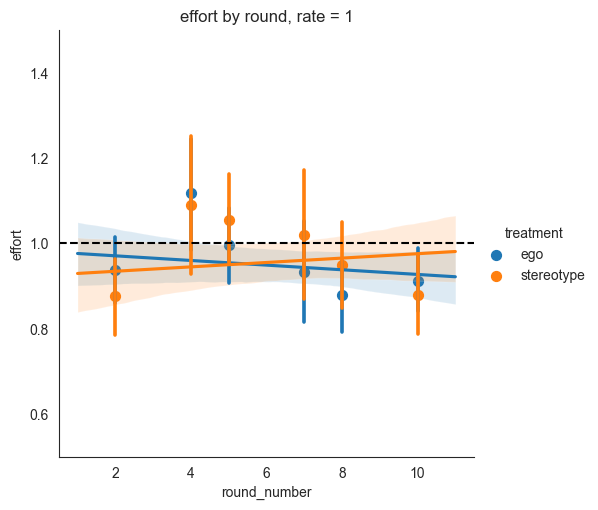

In [776]:
sns.lmplot(data=updates[updates['omega']==1], x='round_number', y='effort', x_bins=6, hue='treatment')
plt.axhline(y=1, color='black', linestyle='--')
plt.ylim(.5, 1.5)
plt.title('effort by round, rate = 1')

Text(0.5, 1.0, 'belief by round, rate = 1')

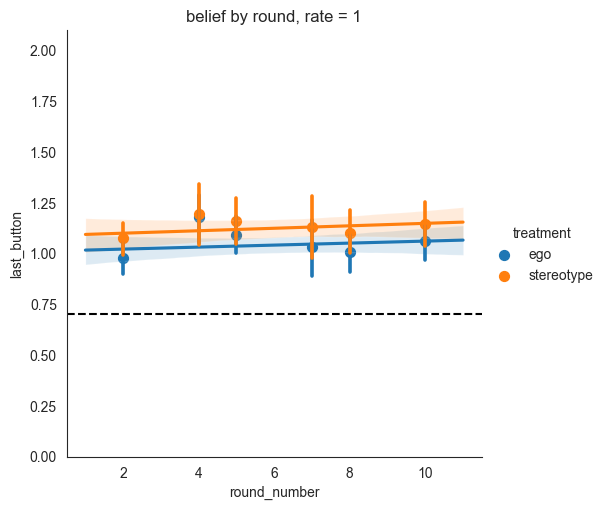

In [777]:
sns.lmplot(data=updates[updates['omega']==1], x='round_number', y='last_button', x_bins=6, hue='treatment')
plt.axhline(y=updates.loc[updates['omega']==1, 'theta'].mean(), color='black', linestyle='--')
plt.ylim(.0, 2.1)
plt.title('belief by round, rate = 1')

Text(0.5, 1.0, 'effort by round, rate = 2')

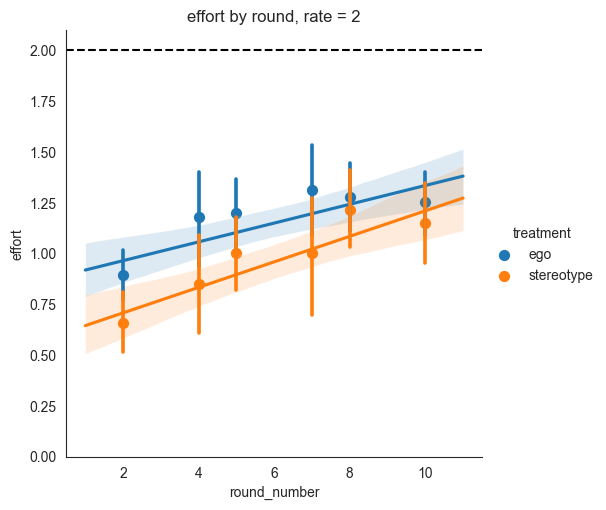

In [778]:
sns.lmplot(data=updates[updates['omega']==2], x='round_number', y='effort', x_bins=6, hue='treatment')
plt.axhline(y=2, color='black', linestyle='--')
plt.ylim(.0, 2.1)
plt.title('effort by round, rate = 2')

Text(0.5, 1.0, 'belief by round, rate = 2')

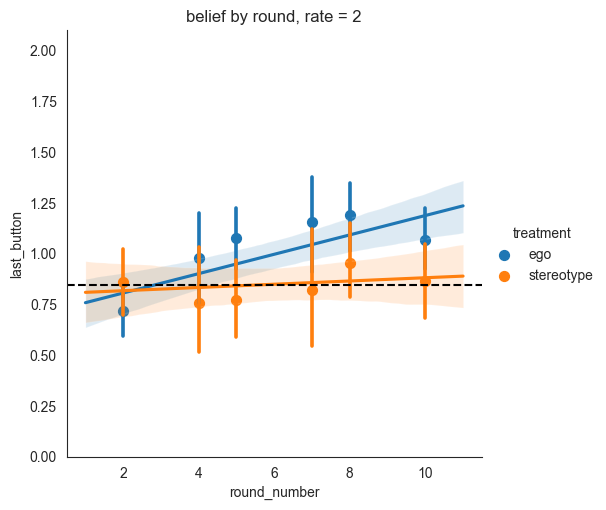

In [779]:
sns.lmplot(data=updates[updates['omega']==2], x='round_number', y='last_button', x_bins=6, hue='treatment')
plt.axhline(y=updates.loc[updates['omega']==2, 'theta'].mean(), color='black', linestyle='--')
plt.ylim(.0, 2.1)
plt.title('belief by round, rate = 2')

In [780]:
# create a column in updates called update_indic that is 1 if the treatment is stereotype
updates['treatment_indic'] = np.where(updates['treatment']=='stereotype', 1, 0)
# create a column in updates called interaction that is the product of update_indic and round_number
updates['interaction'] = updates['treatment_indic']*updates['round_number']
# regress last_button on round_number, update_indic and the interaction between the two
import statsmodels.api as sm
X = updates[['round_number', 'treatment_indic', 'interaction']]
y = updates['effort']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 effort   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.746
Date:                Tue, 26 Sep 2023   Prob (F-statistic):              0.155
Time:                        22:17:27   Log-Likelihood:                -6057.2
No. Observations:                5148   AIC:                         1.212e+04
Df Residuals:                    5144   BIC:                         1.215e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9262      0.031     29.976      0.000       0.866       0.987
round_number       -0.0060      0.005     -1.316      0.188      -0.015       0.003
treatment_indic    -0.0953      0.048     -2.007      0.045      -0.188      -0.002
interaction         0.0094      0.007      1.341      0.180      -0.004       0.023
==============================================================================
Omnibus:                   237428.839   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.046
Skew:                           0.226   Prob(JB):                     2.51e-94
Kurtosis:                       1.657   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [781]:
# ttest if the average effort is different in round 1 and round 11
print('the mean in the first 5 rounds is', np.mean(updates.loc[updates['round_number']<6, 'effort']))
print('the mean in the last 5 rounds is', np.mean(updates.loc[updates['round_number']>6, 'effort']))
stats.ttest_ind(updates.loc[updates['round_number']==1, 'effort'], updates.loc[updates['round_number']==11, 'effort'])

the mean in the first 5 rounds is 0.8940170940170941
the mean in the last 5 rounds is 0.838034188034188


Ttest_indResult(statistic=-3.15191041225887, pvalue=0.0016737648488659347)

In [782]:
# regress effort on round_number
X = updates[['round_number']]
y = updates['effort']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 effort   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3407
Date:                Tue, 26 Sep 2023   Prob (F-statistic):              0.559
Time:                        22:17:27   Log-Likelihood:                -6059.6
No. Observations:                5148   AIC:                         1.212e+04
Df Residuals:                    5146   BIC:                         1.214e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8859      0.023     37.736      0.000       0.840       0.932
round_number    -0.0020      0.003     -0.584      0.559      -0.009       0.005
==============================================================================
Omnibus:                   158775.421   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              432.636
Skew:                           0.225   Prob(JB):                     1.13e-94
Kurtosis:                       1.653   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'belief by round')

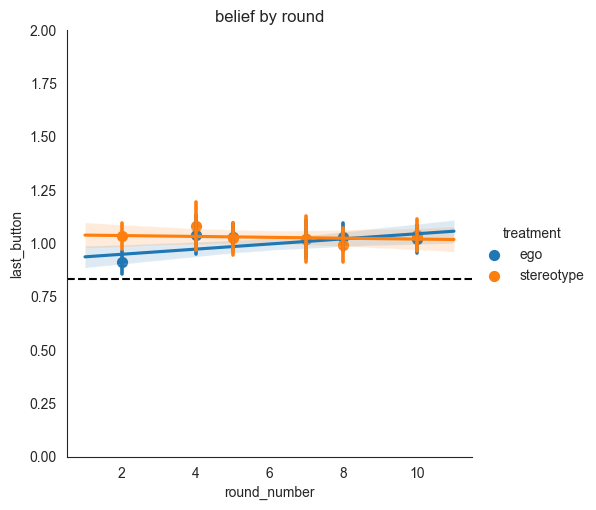

In [783]:
sns.lmplot(data=updates, x='round_number', y='last_button', x_bins=6, hue='treatment')
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylim(0, 2)
plt.title('belief by round')

Text(0.5, 1.0, 'belief by round')

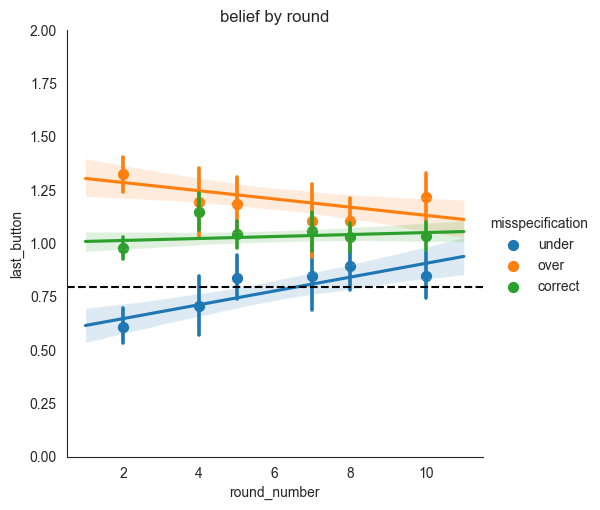

In [784]:
# plot the linear model between rounds and last_button by misspecification
sns.lmplot(data=updates, x='round_number', y='last_button', x_bins=6, hue='misspecification')
plt.axhline(y=np.mean(updates['theta']), color='black', linestyle='--')
plt.ylim(0, 2)
plt.title('belief by round')

Text(0.5, 1.0, 'effort by round, rate = 1')

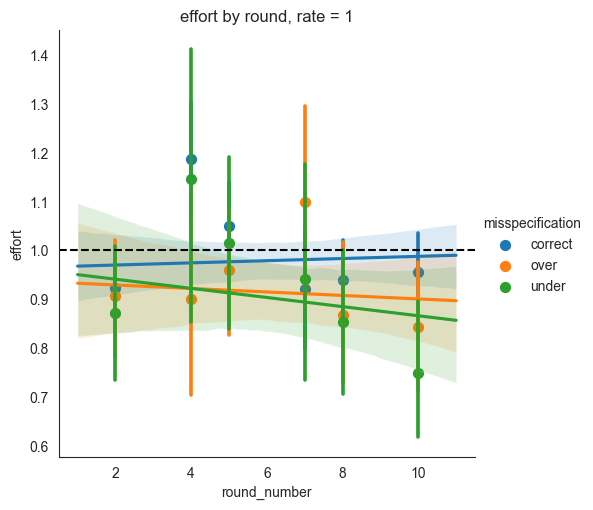

In [785]:
# plot the effort by round by misspecification
sns.lmplot(data=updates[updates['omega']==1], x='round_number', y='effort', x_bins=6, hue='misspecification')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('effort by round, rate = 1')

Text(0.5, 1.0, 'effort by round, rate = 0')

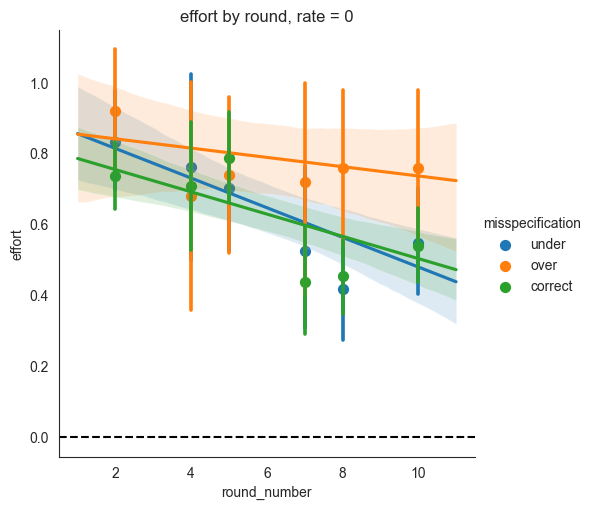

In [786]:
# plot the effort by round by misspecification
sns.lmplot(data=updates[updates['omega']==0], x='round_number', y='effort', x_bins=6, hue='misspecification')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('effort by round, rate = 0')

Text(0.5, 1.0, 'effort by round, rate = 2')

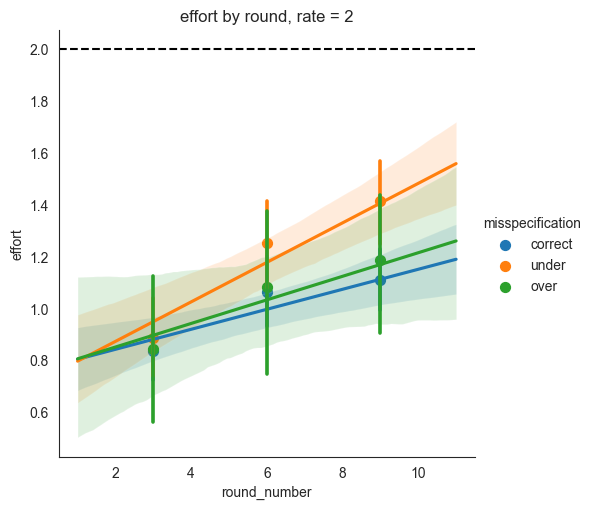

In [787]:
# plot the effort by round by misspecification
sns.lmplot(data=updates[updates['omega']==2], x='round_number', y='effort', x_bins=3, hue='misspecification')
plt.axhline(y=2, color='black', linestyle='--')
plt.title('effort by round, rate = 2')

<Axes: xlabel='belief', ylabel='certainty'>

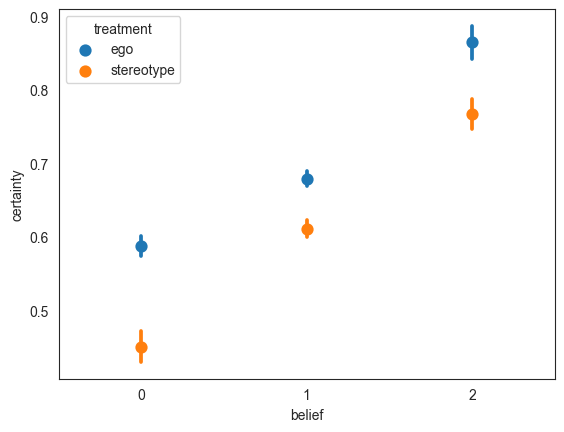

In [788]:
sns.pointplot(data=updates, x='belief', y='certainty', join=False, hue='treatment')

<Axes: xlabel='misspecification', ylabel='certainty'>

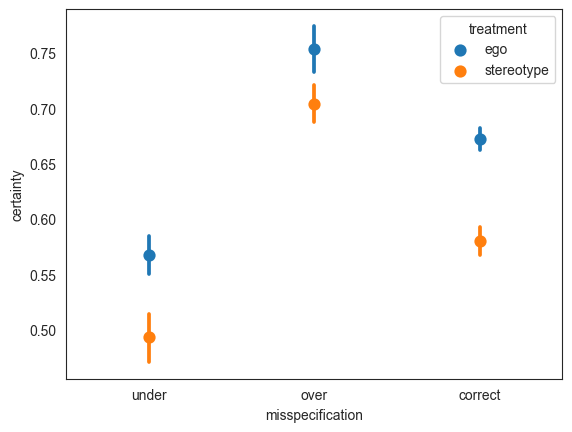

In [789]:
# point plot of the certainty by misspecification and by treatment
sns.pointplot(data=updates, x='misspecification', y='certainty', join=False, hue='treatment')

<Axes: xlabel='topic', ylabel='certainty'>

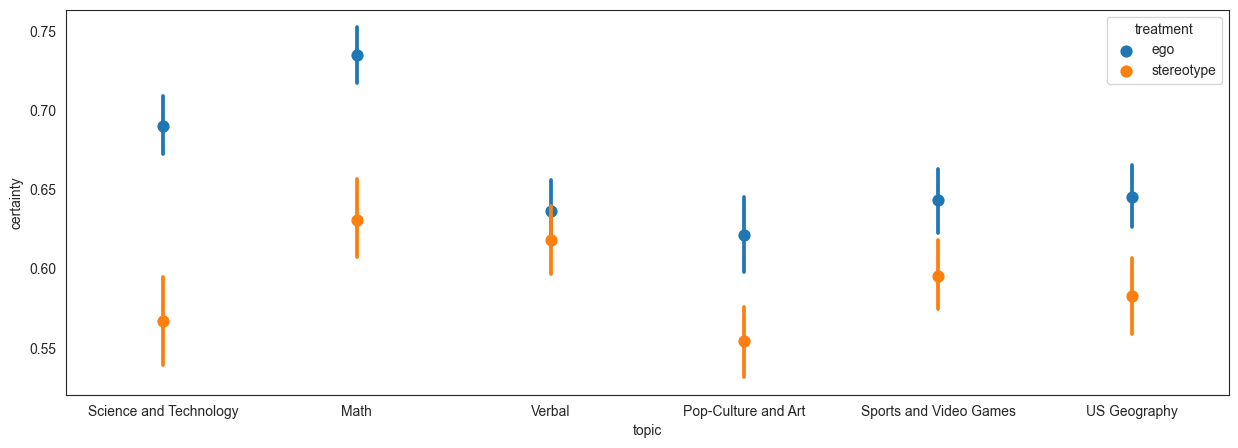

In [790]:
# point plot of the certainty by misspecification and by treatment
plt.figure(figsize=(15, 5))
sns.pointplot(data=updates, x='topic', y='certainty', join=False, hue='treatment')


<Axes: xlabel='topic', ylabel='belief'>

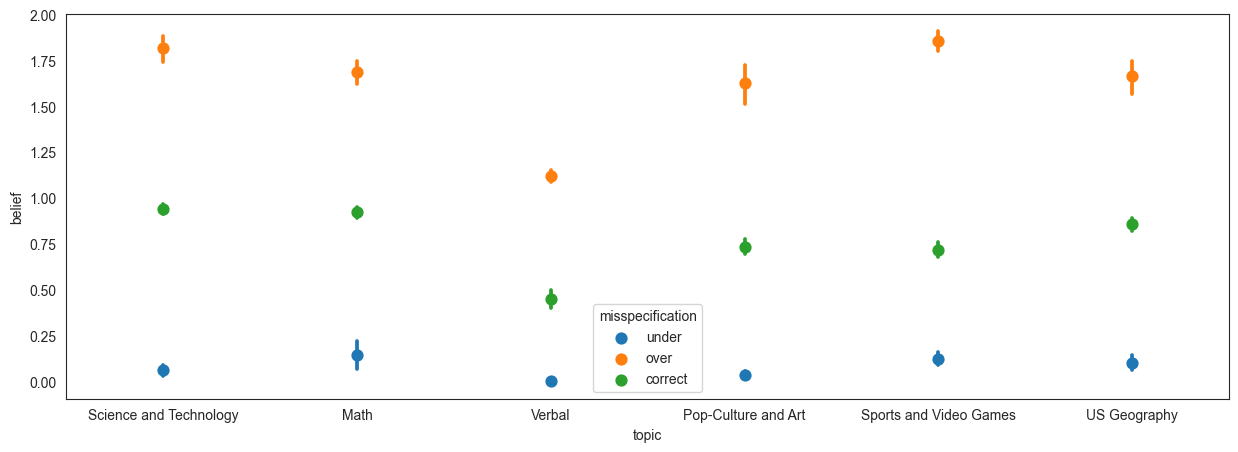

In [791]:
# point plot of the certainty by misspecification and by treatment
plt.figure(figsize=(15, 5))
sns.pointplot(data=updates, x='topic', y='belief', join=False, hue='misspecification')

In [792]:
np.array([updates.loc[updates['change_indicator_sum']==0, 'distance_dogmatic_sum'].mean(),
 updates.loc[updates['change_indicator_sum']==0, 'distance_switcher_sum'].mean(),
 updates.loc[updates['change_indicator_sum']==0, 'distance_bayesian_sum'].mean(),
 updates.loc[updates['change_indicator_sum']==0, 'distance_self-serving_sum'].mean()])/6

array([6.82786885, 6.30054645, 7.63934426, 6.96448087])

## Dogmatic v Switcher

In [793]:
# for the cases in which we can compare between switcher and dogmatic
# get the absolute value distance to the predicted paths
dogmatic_updates['distance_switcher_abs']=np.abs(dogmatic_updates['distance_switcher'])
dogmatic_updates['distance_dogmatic_abs']=np.abs(dogmatic_updates['distance_dogmatic'])

In [794]:
# take the average distance to the predicted path
dogmatic_updates[['distance_switcher_abs', 'distance_dogmatic_abs']].mean()

distance_switcher_abs    0.610000
distance_dogmatic_abs    0.813636
dtype: float64

In [795]:
# test if the distances are different
stats.ttest_ind(dogmatic_updates['distance_dogmatic_abs'], dogmatic_updates['distance_switcher_abs'])

Ttest_indResult(statistic=7.379756918770034, pvalue=2.2369178493153263e-13)

In [796]:
len(dogmatic_updates['player_code'].unique())

100

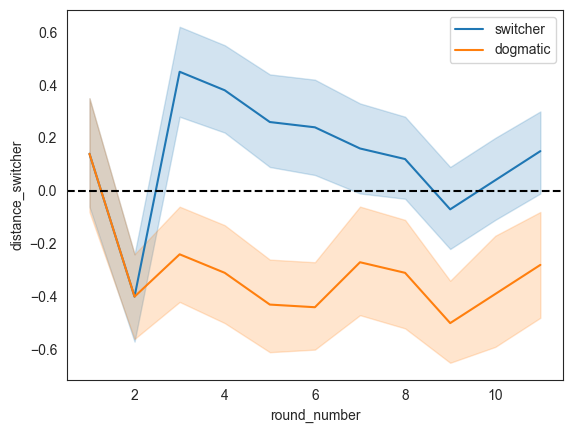

In [797]:
# plot the average distance to the switcher and dogmatic by round
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_switcher', label='switcher')
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic', label='dogmatic')
plt.axhline(y=0, color='black', linestyle='--')

## Byesian V Self-Serving

In [798]:
# take the average distance to the predicted path for bayesian and self-serving
updates[['distance_bayesian_abs', 'distance_self-serving_abs']].mean()

distance_bayesian_abs        0.743978
distance_self-serving_abs    0.696387
dtype: float64

In [799]:
# test if the distances are different
stats.ttest_ind(updates['distance_bayesian_abs'], updates['distance_self-serving_abs'])

Ttest_indResult(statistic=3.485809726966552, pvalue=0.0004926944153083745)

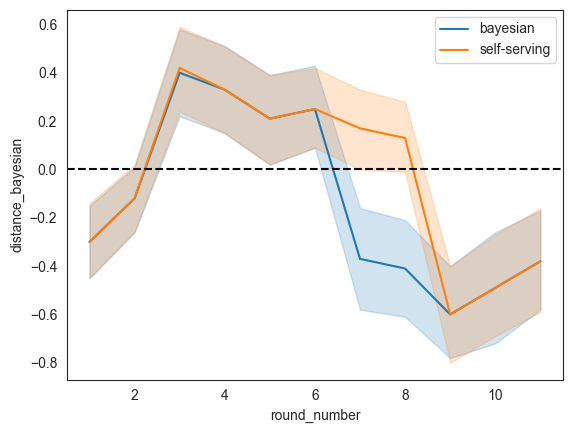

In [800]:
 # plot the average distance to the switcher and dogmatic by round
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_bayesian', label='bayesian')
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_self-serving', label='self-serving')
plt.axhline(y=0, color='black', linestyle='--')

# Calculate the parameters of the self-serving bias

In [801]:
# Load the simulation from the self_serving model
sim_ss = pd.read_csv("../Simulations/demo/data/simulation_ss.csv")


In [802]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'last_button_consistent', 'last_button_correct', 'treatment_indic',
       'interaction', 'topic_num', 'player_code', 'current_belief_start',
       'belief_change', 'change_indicator', 'change_indicator_sum', 'lr',
       'log_lr', 'switcher', 'dogmatic', 'bayesian_ind', 'self-serving_ind',
       'bayesian', 'self-serving', 'switcher_belief', 'distance_bayes',
       'distance_switcher', 'distance_dogmatic', 'distance_bayesian',
       'distance_self-serving', 'distance_switcher_abs',
       'distance_dogmatic_abs', 'distance_bayesian_abs',
       'distance_self-serving_abs', 'distance_switcher_sum',
       'distance_dogmatic_sum', 'distance_bayesian_sum',
       'distance_self-serving_sum'

In [803]:
sim_ss = sim_ss[['round', 'effort', 'theta', 'omega', 'c_good', 'c_bad', 'prior']]
sim_ss.rename(columns={'round':'round_number', 'effort':'effort_sim', 'prior':'certainty'}, inplace=True)

In [804]:
data = updates[['effort', 'round_number', 'certainty', 'belief', 'treatment', 'theta', 'omega', 'player_code', 'code']]

In [805]:
data_sim_ss = data.merge(sim_ss)

In [806]:
data_sim_ss['distance'] = abs(data_sim_ss ['effort']-data_sim_ss['effort_sim'])


In [807]:
distances_ss = data_sim_ss.groupby(['player_code', 'certainty', 'c_good', 'c_bad'])['distance'].sum().reset_index()

In [808]:
distances_ss = distances_ss[distances_ss['c_good']>distances_ss['c_bad']]

In [809]:
# for each player_code, find the values of c_good and c_bad that minimize the distance in distances_ss

min_distance = distances_ss.groupby('player_code').min('distance').reset_index()


In [810]:
c_good_est = min_distance['c_good'].mean()
c_bad_est = min_distance['c_bad'].mean()

In [811]:
print(c_good_est)
print(c_bad_est)

nan
nan
